# <span style="color:green">**Clasificación de Datos MOCAP**</span>

**Estudiante:** <span style="color:blue">Mario García Moncayo </span>
**Director:** <span style="color:blue">Cristhian Kaori Valencia </span>
        
**Fecha:**   <span style="color:blue">22 de abril del 2024</span> 

CLASIFICACIÓN DE DATOS MOCAP SOBRE UNA DISCIPLINA DEPORTIVA USANDO MODELOS DE MACHINE LEARNING


In [1]:
#!pip install pymo
#!pip install pybvh


## <span style="color:blue">**Importar librerías** </span>

Traemos la carpeta **PYMO** previamente descargada en el ordenador local del URL: https://github.com/omimo/PyMO
y copiamos los archivos en la ruta de anaconda-jupyter, para hacer uso de los contenidos y parámetros de la misma, aparte cargamos los demás paquetes que vamos a usar

In [2]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#Load packages
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import pickle
import timeit
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils import shuffle
import joblib
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import joblib  # Cambiado aquí
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report as cr
from sklearn.svm import SVC

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import joblib

import warnings
warnings.filterwarnings("ignore")

## <span style="color:blue">**Importar SHECCO** </span>
Clase principal correspondiente al cálculo de la métrica SHECCO descargada del URL: https://github.com/Ckvalencia/hello-world/blob/master/SHECCO_CMU_sub.ipynb

In [4]:

#clase principal shecco
class SHECCO(BaseEstimator,TransformerMixin):
    def __init__(self, sigmax = 54, sigmay = 54, Ax = 1, Ay = 1,ws = 5, noverlap = None, k = 50, sup = 1):
        self.sigmax = sigmax
        self.sigmay = sigmay
        self.ws = ws
        self.noverlap = noverlap
        self.sup = sup
        self.k = k
        self.Ax = Ax
        self.Ay = Ay
        
##################################################################

    def plot_mocap(self, Ns, Nv, ind):
     mp_p = MocapParameterizer(param_type = 'position')
     data_all = [p.parse('D:/Escritorio/datos_mocap/'+Ns+'/'+list_folder[Nv])]
     pos_d= mp_p.fit_transform(data_all)
     #Normalization
     n=pos_d[0].values
     P = np.asarray(pos_d[0].values)
     z = P.reshape(n.shape[0],38,3)
     Z = np.zeros(z.shape)
     for i in range(z.shape[0]):
       for j in range(z.shape[1]):
         Z[i,j,:] =z[i,j,:]- z[i,0,:]       
    
     print(f"Shape of ind: {ind.shape}")
     print(f"Shape of Z: {Z.shape}")
    
     #Distance among skeletons
     for k in range(ind.shape[0]):
       for l in range(Z.shape[1]):
         Z[ind[k],l,0]= Z[ind[k],l,0]+20*k
     Z = Z.reshape(n.shape[0],114)
     n.iloc[:]=Z[:]
     pos_d[0].values = n

     if ind.shape[0]<= 10:
       draw_stickfigure(pos_d[0], frame = ind, figsize=(20,4))
     else: 
       nf = int(ind.shape[0]/10)
       for h in range(0,nf):
         draw_stickfigure(pos_d[0], frame = ind[10*h:10*(h+1)], figsize=(20,4))
         plt.show()

########################################

    def geneout_(self,X):
      #print(X.shape)
      N,T = X.shape
      Y = np.zeros((N,T))
      for n in range(N):
        for t in range(T-1):
          Y[n,t]=X[n,t+1]
      return Y

    def ventaneo_(self,X):
       N,P = X.shape
       if self.noverlap == None: self.noverlap =0
       if self.ws == None: self.ws = P
       for j in range(N):
         pi = 0
         pf = self.ws
         Xi = X[j,pi:pf].reshape(1,-1) 
         Yi = X[j,pf].reshape(1,-1)
         pi = pi + (self.ws - self.noverlap)
         pf = pi +self.ws
         while pf  < P:
                Xi = np.r_[Xi,X[j,pi:pf].reshape(1,-1)]
                Yi = np.r_[Yi,X[j,pf].reshape(1,-1)]
                pi = pi + (self.ws - self.noverlap)
                pf = pi +self.ws
                #print(Xi,Yi)
         #print(pi,pf)
         if pf >= P:
            temp = X[j,pi:].reshape(1,-1)
            Xi = np.r_[Xi,np.c_[temp,np.zeros(self.ws-temp.shape[1]).reshape(1,-1)]]
            Yi = np.r_[Yi,np.zeros(1).reshape(-1,1)]       
         if j == 0: 
           #print(Xi.shape)
           X_ = np.zeros((N,Xi.shape[0],Xi.shape[1]))
           Y_ = np.zeros((N,Yi.shape[0],1))
         X_[j] = Xi  
         Y_[j] = Yi  
       return X_,Y_  

    def SC_(self,X,Y):
        Xcl = np.zeros((X.shape[0], self.k))
        Ycl = np.zeros((Y.shape[0], self.k))
        for n in range(X.shape[0]):
            Z = X[n]
            L = Y[n]
            Z = np.tile(Z,(Z.shape[0],1))
            D = pairwise_distances(Z,Z)
            gamma = 1/(np.median(D)**2)
            K = np.exp(-0.5*gamma*D**2)
            Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
            y_pred = Clus.fit_predict(K)
            centers = np.zeros((self.k,Z.shape[1]))
            for c in range(self.k):
                centers[c] = Z[y_pred==c].mean(axis=0)
                
            Ds = pairwise_distances(centers,Z)
            ind = np.argmin(Ds,axis=1) 
            Xcl[n] = Z[ind]
            Ycl[n] = L[ind]
        return Xcl,Ycl

    def SC_Mocap(self,X,Y):
      Xcl = np.zeros((self.k, X.shape[1]))
      Ycl = np.zeros((self.k, Y.shape[1]))
      D = pairwise_distances(Y,Y)
      gamma = 1/(np.median(D)**2)
      K = np.exp(-0.5*gamma*D**2)
      Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
      y_pred = Clus.fit_predict(K)
      centers = np.zeros((self.k,Y.shape[1]))
      for c in range(self.k):
        centers[c] = Y[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,Y)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      Ycl = Y[ind]
      return Xcl,Ycl,ind


    def Kmeans_Mocap(self,X):
      Xcl = np.zeros((self.k, X.shape[1]))
      #Ycl = np.zeros((self.k, Y.shape[1]))
      #Clus = KMeans(n_clusters= self.k, random_state=0)
      y_pred = KMeans(n_clusters= self.k, random_state=0).fit_predict(X)
      centers = np.zeros((self.k,X.shape[1]))
      for c in range(self.k):
        centers[c] = X[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,X)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      #Ycl = Y[ind]
      return Xcl,ind

    def kergM(self,X,Y,sigma_,A):
       return A*np.exp(-pairwise_distances(X,Y)**2/(2*sigma_**2))
    
    def shecco_(self,X,Y,Z,L,pxx,pyy,pzz,pll,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1)#.dot(pxx.reshape(1,-1))
          PYY = pyy.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZZ = pzz.reshape(-1,1)#.dot(pzz.reshape(1,-1))  
          PLL = pll.reshape(-1,1)#.dot(pll.reshape(1,-1))  
          PXY = pxx.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZL = pzz.reshape(-1,1)#.dot(pll.reshape(1,-1))  
      KXX  = self.kergM(X,X,self.sigmax,self.Ax)
      KZZ  = self.kergM(Z,Z,self.sigmax,self.Ax)
      KYY  = self.kergM(Y,Y,self.sigmay,self.Ay)
      KLL  = self.kergM(L,L,self.sigmay,self.Ay)
      KXZ  = self.kergM(X,Z,self.sigmax,self.Ax)
      KYL  = self.kergM(Y,L,self.sigmay,self.Ay)


      #trxx=KXX.shape[0]**2 #np.sqrt(np.trace((KXX.dot(KXX))))
  
      #trzz=KZZ.shape[0]**2#np.sqrt(np.trace((KZZ.dot(KZZ))))
    
      #tryy=KYY.shape[0]**2#np.sqrt(np.trace((KYY.dot(KYY))))
     
      #trll=KLL.shape[0]**2#np.sqrt(np.trace((KLL.dot(KLL))))
    
      #trxz=KXX.shape[0]*KZZ.shape[0]#np.sqrt(np.trace((KXZ.dot(KXZ.T))))
     
      #tryl=KYY.shape[0]*KLL.shape[0]#np.sqrt(np.trace((KYL.dot(KYL.T))))
      #KXX = KXX*trxx
      #KZZ = KZZ*trzz
      #KYY = KYY*tryy
      #KLL = KLL*trll
      #KXZ = KXZ*trxz
      #KYL = KYL*tryl

   # Distancia     
      #d = np.trace((PXX*KXX).dot(KYY*PYY)) -2*np.trace((PXZ*KXZ).dot((KYL*PYL).T)) + np.trace((PZZ*KZZ).dot(KLL*PLL))
      d = (PXY.T).dot(KXX*KYY).dot(PXY) -2*(PXY.T).dot(KXZ*KYL).dot(PZL) + (PZL.T).dot(KZZ*KLL).dot(PZL)

      if d<0:
        d = abs(d)
      return d

    #hecco sin salida (no supervised)
    def hecco_(self,X,Z,pxx,pzz,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1).dot(pxx.reshape(1,-1))
          PZZ = pzz.reshape(-1,1).dot(pzz.reshape(1,-1))   
          PXZ = pxx.reshape(-1,1).dot(pzz.reshape(1,-1)) 
      KXX  = self.kergM(X,X,self.sigmax)
      KZZ  = self.kergM(Z,Z,self.sigmax)
      KXZ  = self.kergM(X,Z,self.sigmax)
      
      d = np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXX*KXX)),np.ones(PXX.shape[0]))-2*np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXZ*KXZ)),np.ones(PZZ.shape[0]))+ np.dot(np.dot(np.ones(PZZ.shape[0]).T,(PXX*KXX)),np.ones(PZZ.shape[0]))
     
      if d<0:
        d = abs(d)
      return d   

    def SHECCO_M_(self,Xtrain_,Xtest_,Ytrain_,Ytest_,pzz,pll): # Matriz de Gramm Kernel RKHS
      Ntrain = Xtrain_.shape[0]
      Ntest = Xtest_.shape[0]
        
      Dte_tr = np.zeros((Ntest,Ntrain))
      for i in range(Ntrain):
        for j in range(Ntest):
          if self.sup == None:
              Dte_tr[j,i] = self.hecco_(Xtrain_[i],Xtest_[j],self.pxx,pzz)
          else:
            Dte_tr[j,i] = self.shecco_(Xtrain_[i],Ytrain_[i],Xtest_[j],Ytest_[j],
                       self.pxx,self.pyy,pzz,pll)
      return Dte_tr

    def fit(self,X,*_):
        #self.Xtrain_,self.Ytrain_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
           # self.Xtrain_, self.Ytrain_= self.SC_(self.Xtrain_,self.Ytrain_)
        self.Xtrain_= X
        Ya = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Ya[i,:,:]= L.T
        Yp = Ya.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Ytr = pca.fit(Yp).transform(Yp)  
        Y = Ytr.reshape(X.shape[0], X.shape[1], Ytr.shape[1])
        self.Ytrain_= Y
        self.N = self.Xtrain_.shape[1]
        #estimar pdfs
        self.pxx = (1/self.N)*np.ones(self.N) #prob uniformes
        self.pyy = (1/self.N)*np.ones(self.N)
        return self

    def transform(self,X): #Xt_=[Xt,Yt]
        #Xtest_,Ytest_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
        Xtest_ = X
        Yb = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Yb[i,:,:]= L.T
        Yp = Yb.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Yte = pca.fit(Yp).transform(Yp)  
        Y = Yte.reshape(X.shape[0], X.shape[1], Yte.shape[1])
        Ytest_ = Y
        M = Xtest_.shape[1]
        #estimar pdfs
        pzz = (1/M)*np.ones(M) #porbas uniformes
        pll = (1/M)*np.ones(M)
        return self.SHECCO_M_(self.Xtrain_,Xtest_,self.Ytrain_,Ytest_,pzz,pll)

    def fit_tranform(self,X):
        self.fit(X)
        return self.transform(X)

## <span style="color:blue">**Importar DATOS MOCAP** </span>

Cargamos los datos previamente descargados del URL: https://github.com/jdpulgarin/Tennis-MoCap

In [5]:
#The data directory is established
list_folder = os.listdir('D:/Escritorio/datos_mocap/') 
list_folder = sorted(list_folder)
print(list_folder[:20])
print('******************************************************************************************************')
first_data = list_folder[:2]
print(first_data)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', 'desktop.ini']
******************************************************************************************************
['01', '02']


In [6]:
import os

# Establece el directorio de datos
data_directory = 'D:/Escritorio/datos_mocap/'

# Obtén la lista de archivos en el directorio y ordénalos
list_folder = os.listdir(data_directory)
list_folder = sorted([f for f in list_folder if f.lower() != 'desktop.ini'])

# Imprime los primeros 20 archivos
print(list_folder[:20])
print('******************************************************************************************************')

# Imprime los primeros 2 archivos
first_data = list_folder[:2]
print(first_data)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
******************************************************************************************************
['01', '02']


In [7]:
import os
from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *

p = BVHParser()
print(p)
mp = MocapParameterizer(param_type='position')
pos_cent = {}
directory_path = 'D:/Escritorio/datos_mocap/'
print(f"Contents of {directory_path}:")
try:
    contents = os.listdir(directory_path)
    for item in contents:
        print(item)
except PermissionError as e:
    print(f"Permission error for directory {directory_path}: {e}")
except FileNotFoundError as e:
    print(f"Directory not found: {directory_path}: {e}")

print(f"Checking files in list_folder:")

for i in range(len(list_folder)):
#for i in range(len(first_data)):
    dir_path = os.path.join(directory_path, list_folder[i])
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            if os.path.isfile(file_path):
                try:
                    with open(file_path, 'r') as file:
                        data_all = [p.parse(file_path)]
                        pos_cent[i] = mp.fit_transform(data_all)
                        print(f"Successfully processed {file_path}")
                except PermissionError as e:
                    print(f"Permission error for {file_path}: {e}")
                except FileNotFoundError as e:
                    print(f"File not found: {file_path}: {e}")
                except Exception as e:
                    print(f"An error occurred: {e}")
    else:
        print(f"{dir_path} is not a directory.")


Contents of D:/Escritorio/datos_mocap/:
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
desktop.ini
Checking files in list_folder:
Successfully processed D:/Escritorio/datos_mocap/01\adorozco_Derecha.bvh
Successfully processed D:/Escritorio/datos_mocap/01\adorozco_Remate.bvh
Successfully processed D:/Escritorio/datos_mocap/01\adorozco_Reves.bvh
Successfully processed D:/Escritorio/datos_mocap/01\adorozco_Servicio.bvh
Successfully processed D:/Escritorio/datos_mocap/01\adorozco_VDerecha.bvh
Successfully processed D:/Escritorio/datos_mocap/01\adorozco_VReves.bvh
Successfully processed D:/Escritorio/datos_mocap/02\astrejos_Derecha.bvh
Successfully processed D:/Escritorio/datos_mocap/02\astrejos_Remate.bvh
Successfully processed D:/Escritorio/datos_mocap/02\astrejos_Reves.bvh
Successfully processed D:/Escritorio/datos_mocap/02\astrejos_Servicio.bvh
Successfully processed D:/Escritorio/datos_mocap/02\astrejos_VDerecha.bvh
Successfully processed D:/Escritorio/datos_mocap/02\astrejos_VReves.bvh


## <span style="color:blue">**Preprocesamiento de los datos** </span>

In [8]:
#Normalization with respect to hips positions
for k in range(len(pos_cent)): 
  n=pos_cent[k][0].values # recorriendo uno a uno los datos y solo traiga la posición 0
  p = np.asarray(n)
  X = p.reshape(n.shape[0],69,1)
  Z = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i,j,:] =X[i,j,:]- X[i,0,:]
  Z = Z.reshape(n.shape[0],69)   
  n.iloc[:]=Z[:]
  pos_cent[k][0].values = n
  print(pos_cent)

{0: [<pymo.data.MocapData object at 0x00000230689B6D10>], 1: [<pymo.data.MocapData object at 0x0000023066AEEBD0>], 2: [<pymo.data.MocapData object at 0x0000023062C074D0>], 3: [<pymo.data.MocapData object at 0x000002306A8AB850>], 4: [<pymo.data.MocapData object at 0x0000023062BEFC50>], 5: [<pymo.data.MocapData object at 0x0000023063FE7050>], 6: [<pymo.data.MocapData object at 0x00000230690AC550>], 7: [<pymo.data.MocapData object at 0x000002306D114D10>], 8: [<pymo.data.MocapData object at 0x000002306A9A5690>], 9: [<pymo.data.MocapData object at 0x000002306B066990>], 10: [<pymo.data.MocapData object at 0x0000023068077950>], 11: [<pymo.data.MocapData object at 0x000002306B294710>], 12: [<pymo.data.MocapData object at 0x00000230691D8DD0>], 13: [<pymo.data.MocapData object at 0x000002306ABE63D0>], 14: [<pymo.data.MocapData object at 0x00000230689B6A90>]}
{0: [<pymo.data.MocapData object at 0x00000230689B6D10>], 1: [<pymo.data.MocapData object at 0x0000023066AEEBD0>], 2: [<pymo.data.MocapData

In [9]:
# Supongamos que pos_cent es un diccionario. Puedes ajustarlo según tu estructura de datos.
# Aquí hay un ejemplo de cómo podrías evitar el KeyError:

# Imprime las claves de pos_cent para depuración
print(f"Keys in pos_cent: {list(pos_cent.keys())}")

# Normalization with respect to hips positions
for k in range(len(pos_cent)): 
    if k in pos_cent:
        n = pos_cent[k][0].values  # recorriendo uno a uno los datos y solo traiga la posición 0
        p = np.asarray(n)
        X = p.reshape(n.shape[0], 69, 1)
    else:
        print(f"Key {k} not found in pos_cent")

Keys in pos_cent: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
print(p)

[[  0.         130.180943   -13.513023   ...  -2.01992089 205.1979253
  -15.44519822]
 [  0.         130.172188   -13.490577   ...  -2.35121908 205.21745888
  -15.25257711]
 [  0.         130.143772   -13.470882   ...  -2.34681257 205.18614147
  -15.23625654]
 ...
 [  0.         186.241203    59.312828   ... -35.18665028 232.30375658
  101.00834619]
 [  0.         186.241203    59.312828   ... -35.18661754 232.30386369
  101.00830756]
 [  0.         186.241203    59.312828   ... -35.18657139 232.30380167
  101.0083948 ]]


In [11]:
# Definir ind
ind = []
ind = np.array([i for i in range(len(pos_cent))])
print(ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [12]:
#dist = SHECCO()
#dist.plot_mocap(Ns='a', Nv=0, ind=ind[0,:])

# graficas en ciclo for

Processing D:/Escritorio/datos_mocap/01\adorozco_Derecha.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_Remate.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_Reves.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_Servicio.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_VDerecha.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_VReves.bvh
Processing D:/Escritorio/datos_mocap/02\astrejos_Derecha.bvh
Processing D:/Escritorio/datos_mocap/02\astrejos_Remate.bvh
Processing D:/Escritorio/datos_mocap/02\astrejos_Reves.bvh
Processing D:/Escritorio/datos_mocap/02\astrejos_Servicio.bvh
Processing D:/Escritorio/datos_mocap/02\astrejos_VDerecha.bvh
Processing D:/Escritorio/datos_mocap/02\astrejos_VReves.bvh
Processing D:/Escritorio/datos_mocap/03\cferrero_Derecha.bvh
Processing D:/Escritorio/datos_mocap/03\cferrero_Remate.bvh
Processing D:/Escritorio/datos_mocap/03\cferrero_Reves_21seg.bvh
Processing D:/Escritorio/datos_mocap/03\cferrero_Servicio.bvh
Processing D:/Escritorio

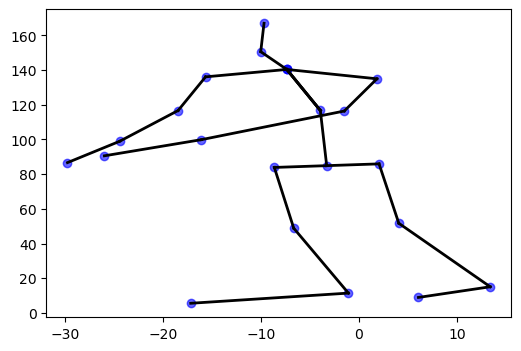

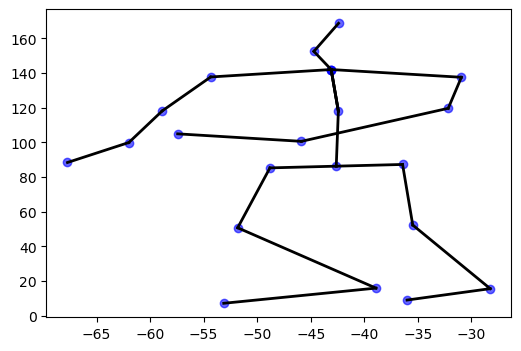

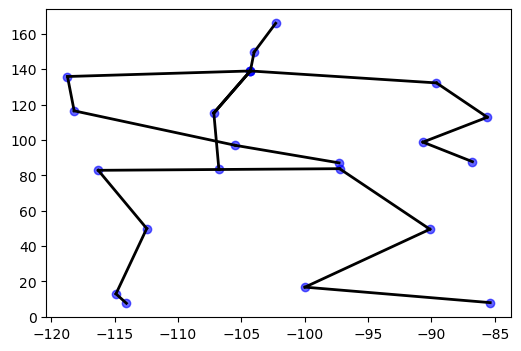

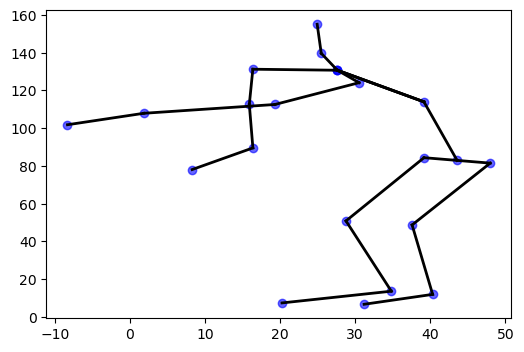

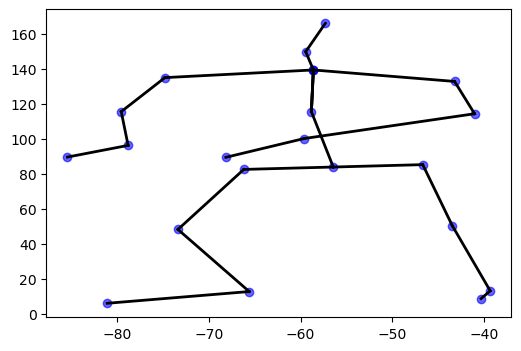

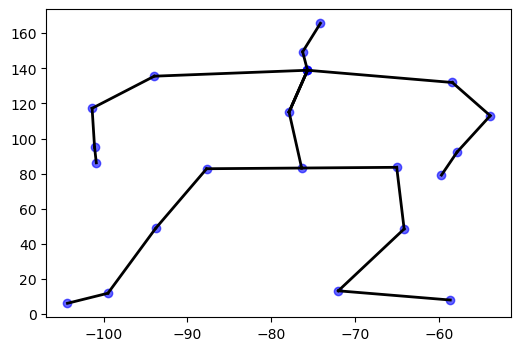

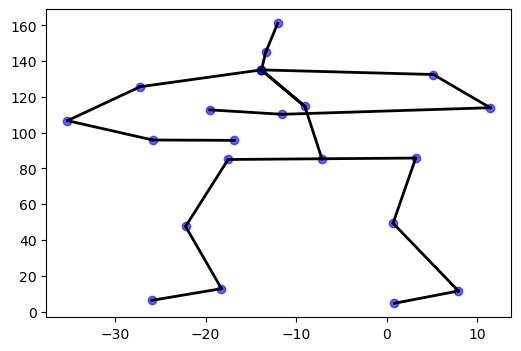

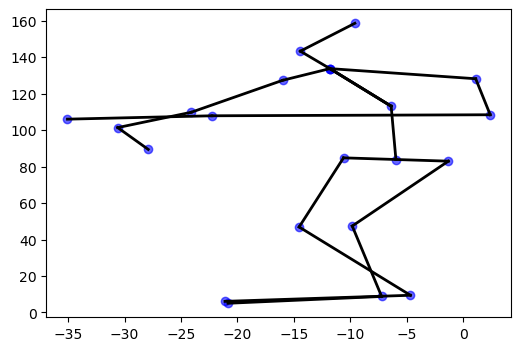

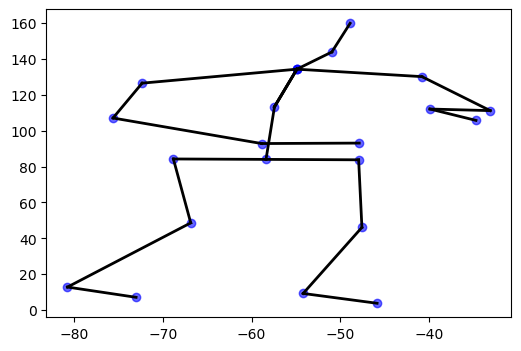

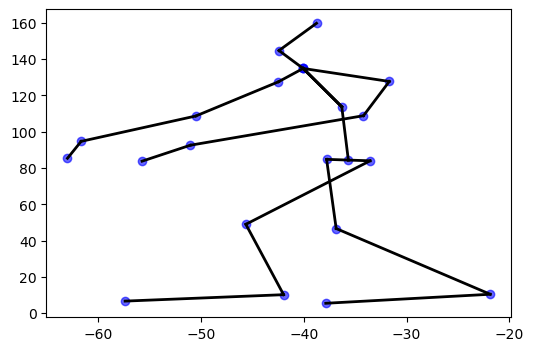

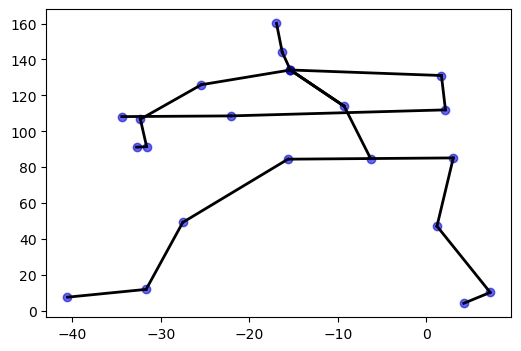

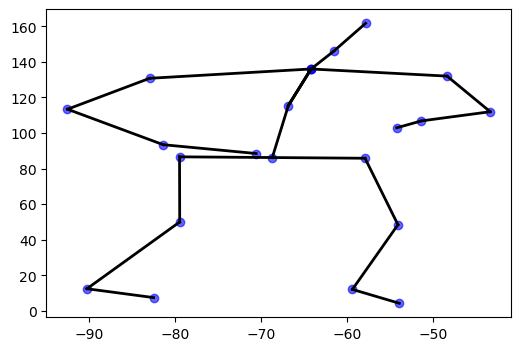

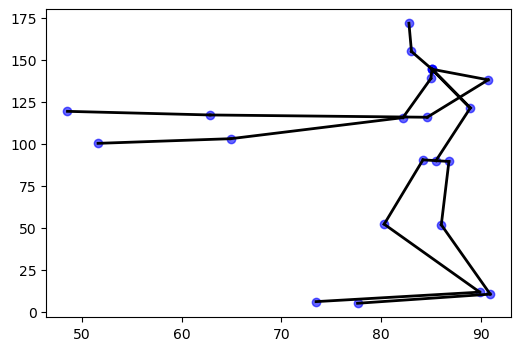

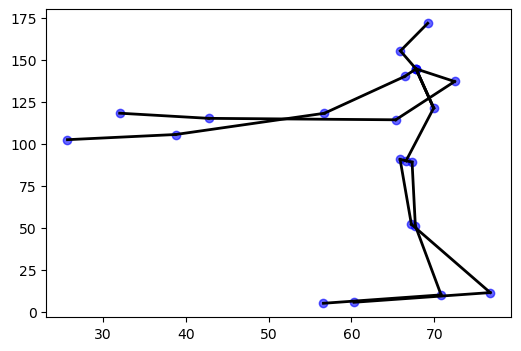

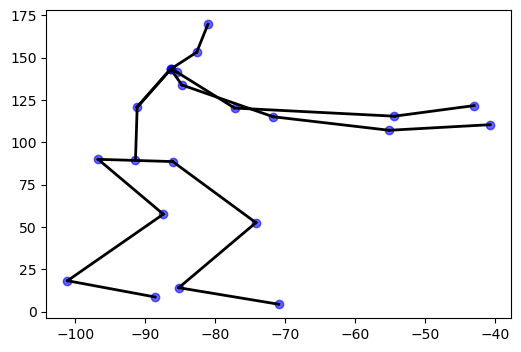

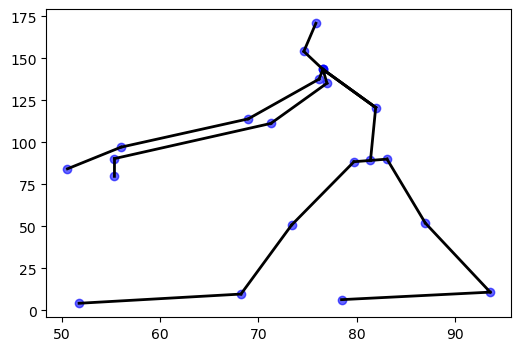

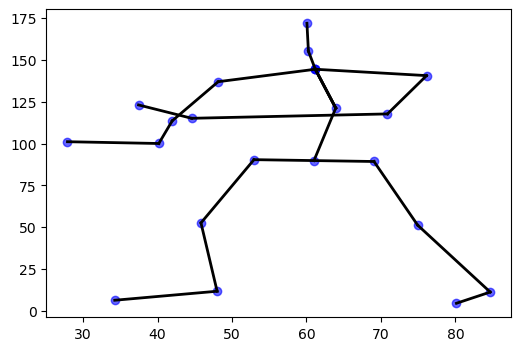

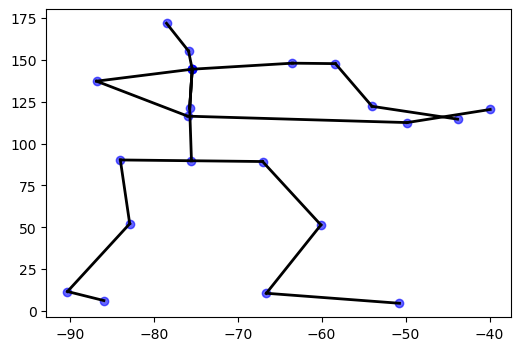

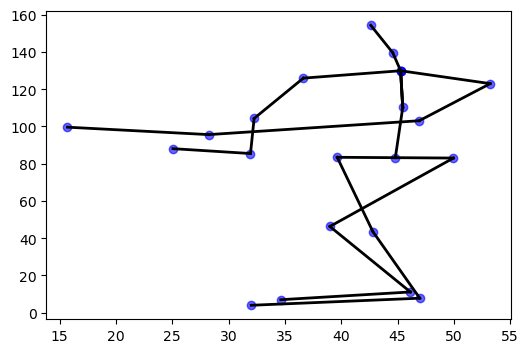

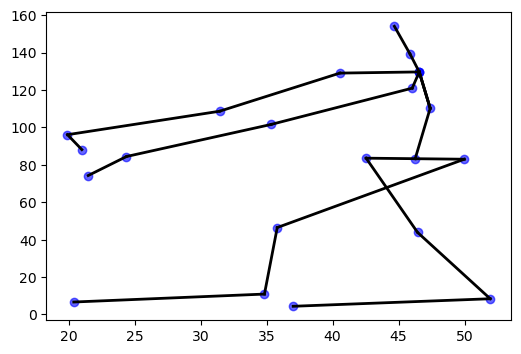

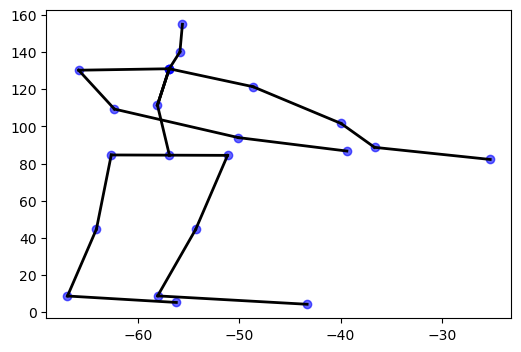

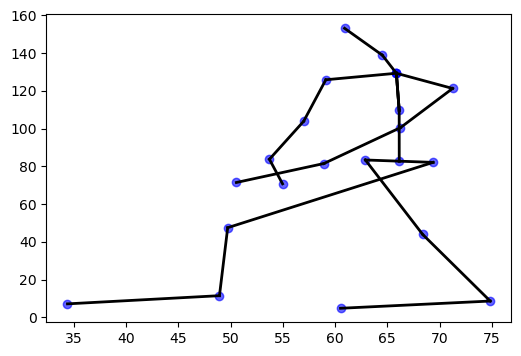

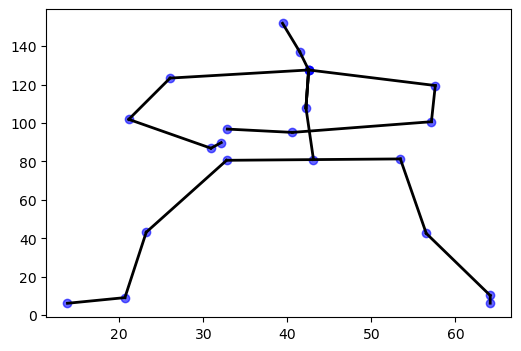

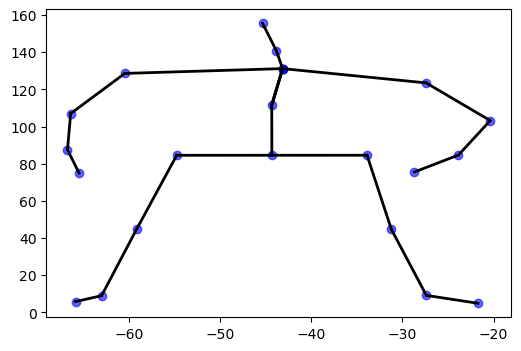

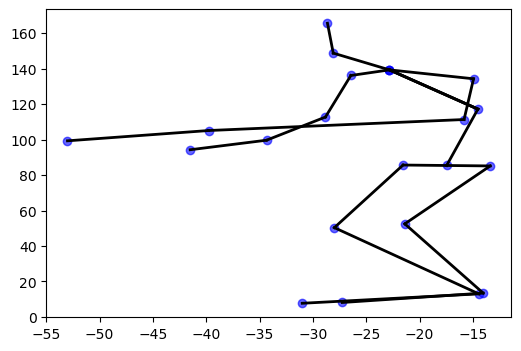

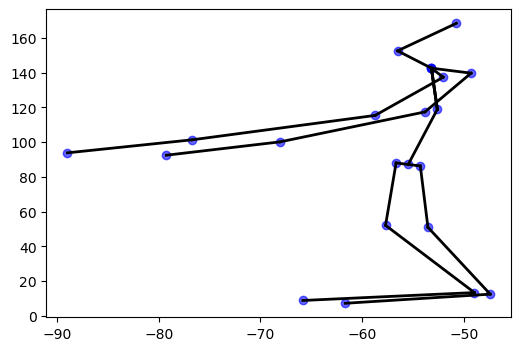

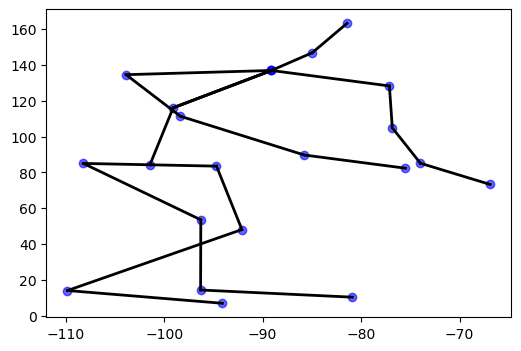

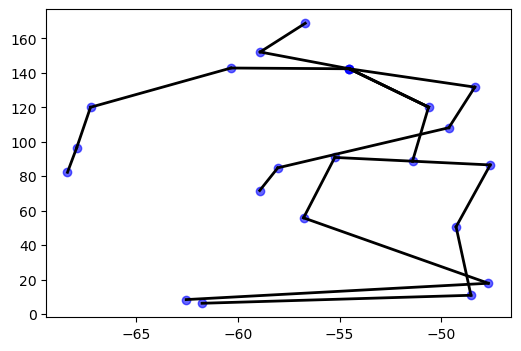

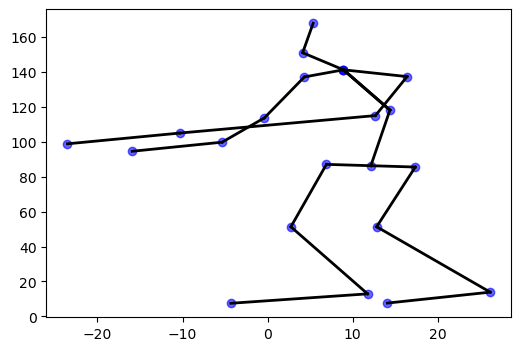

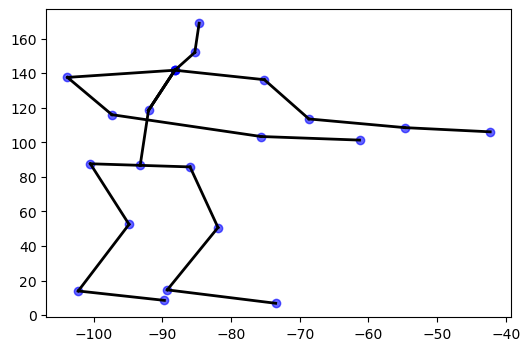

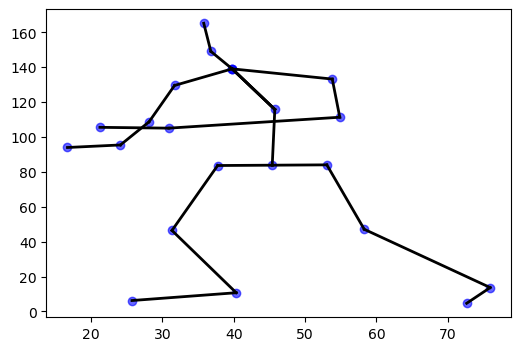

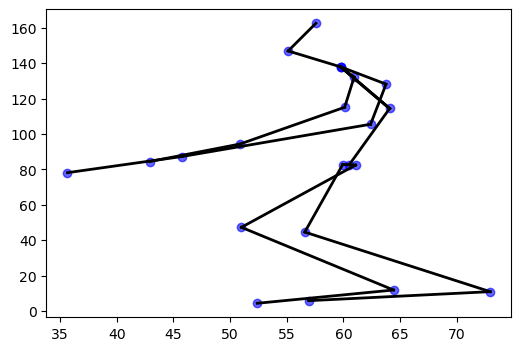

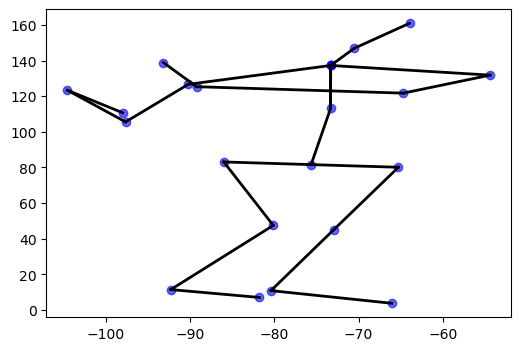

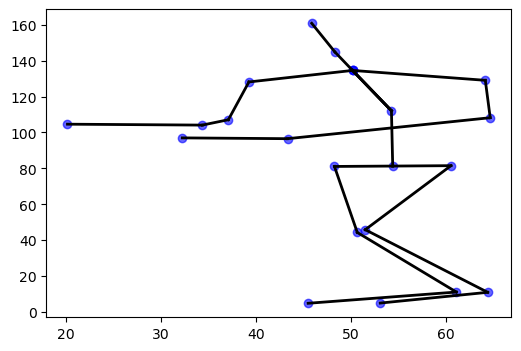

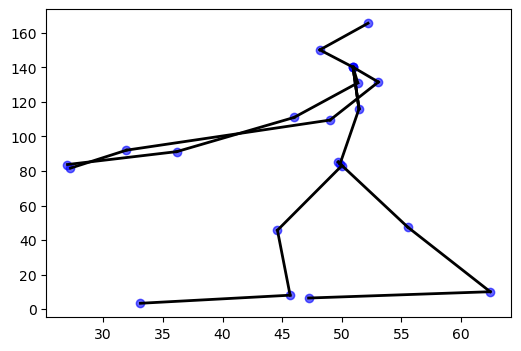

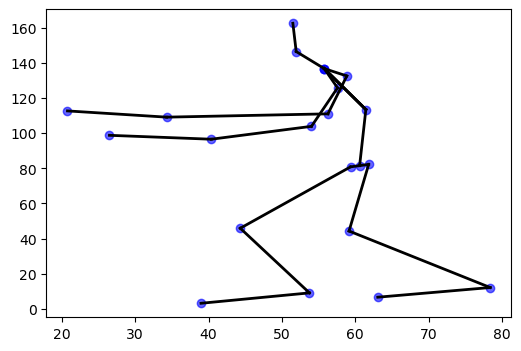

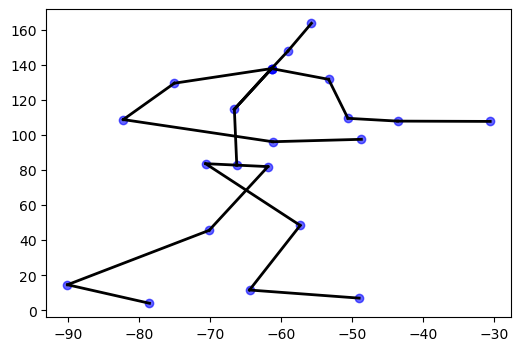

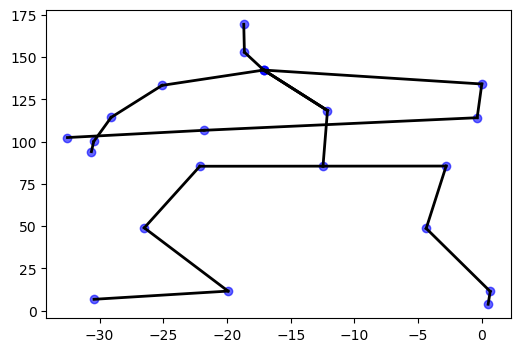

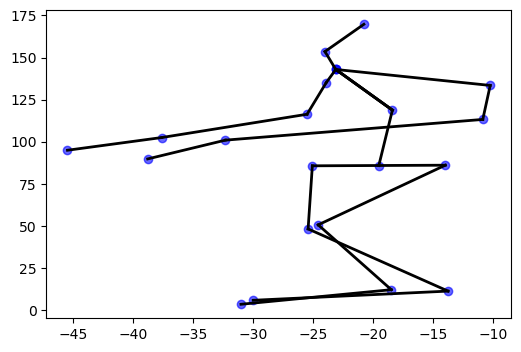

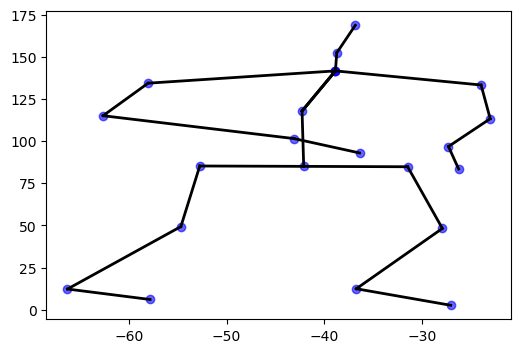

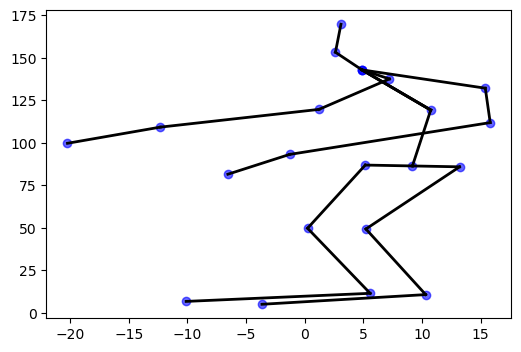

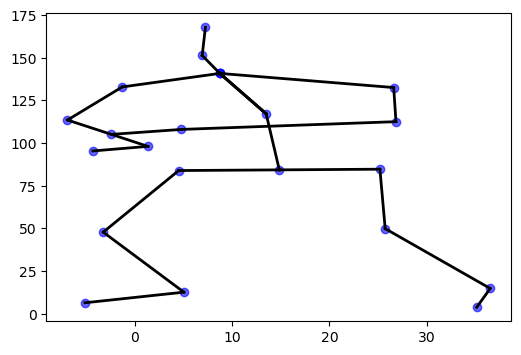

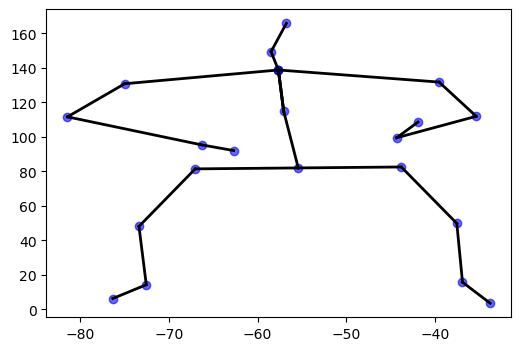

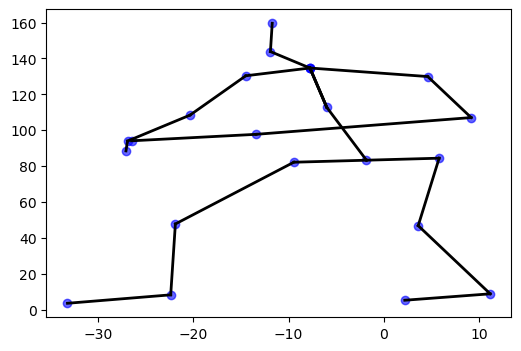

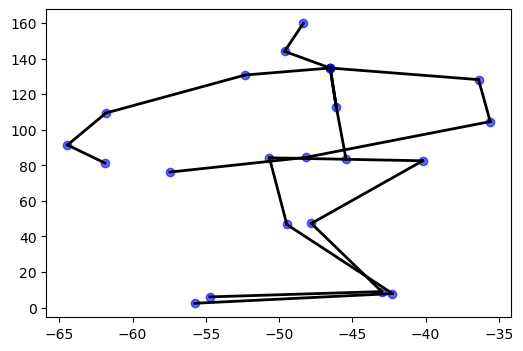

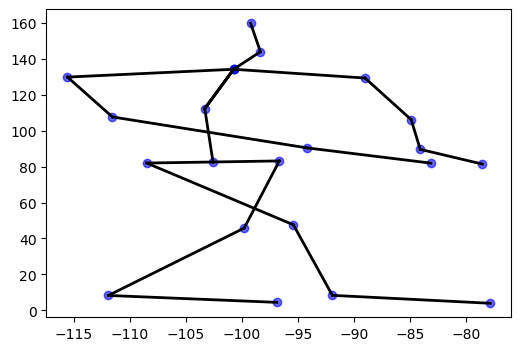

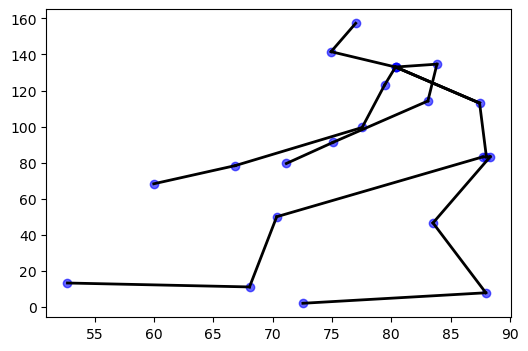

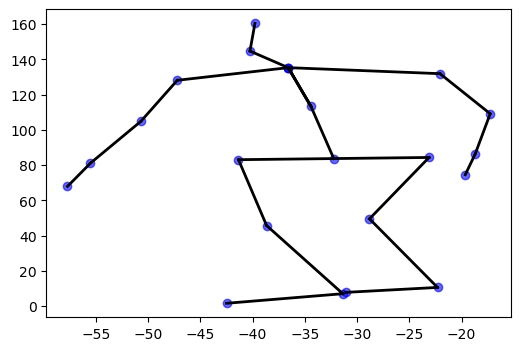

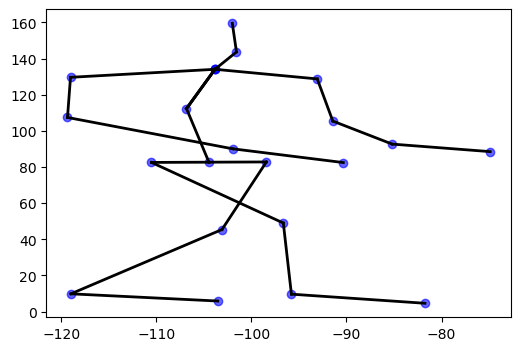

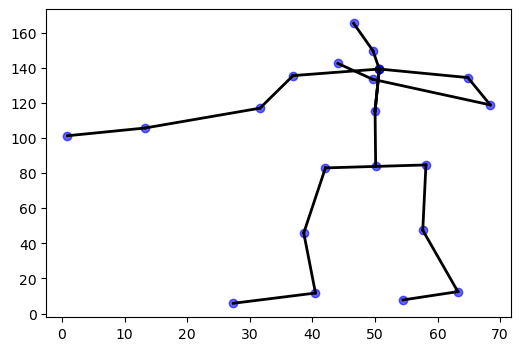

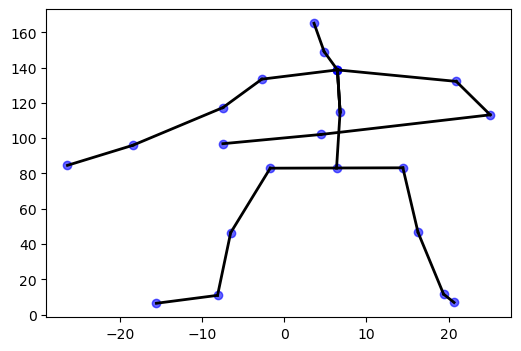

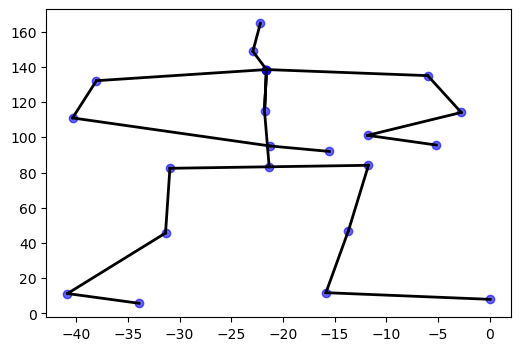

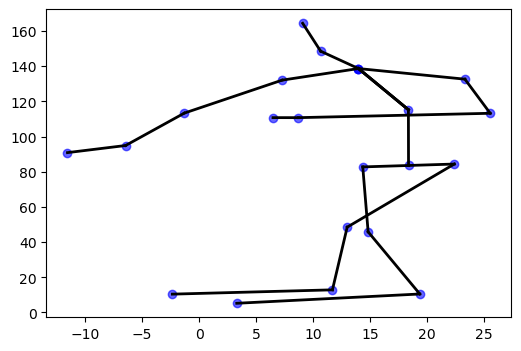

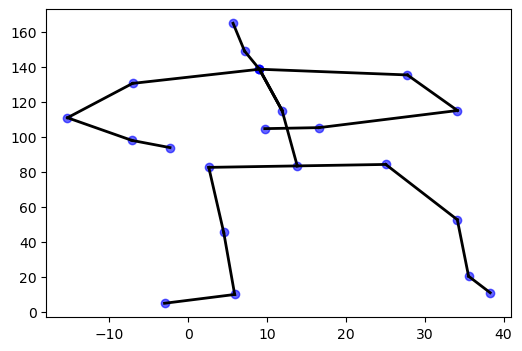

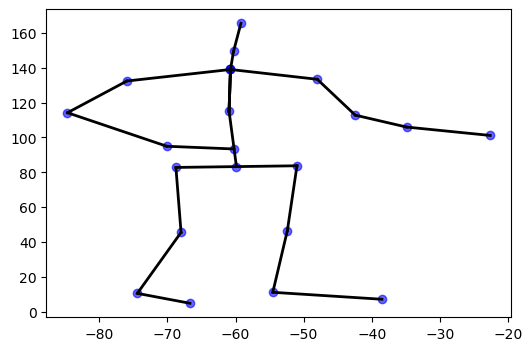

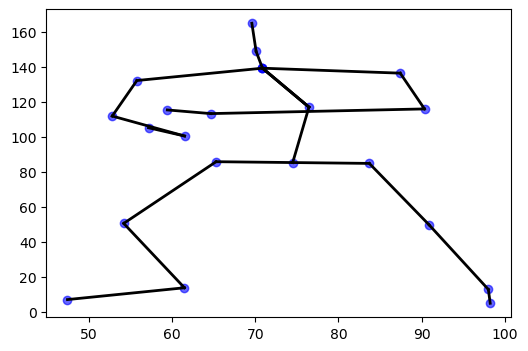

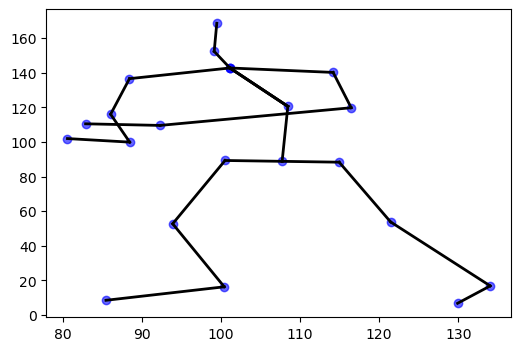

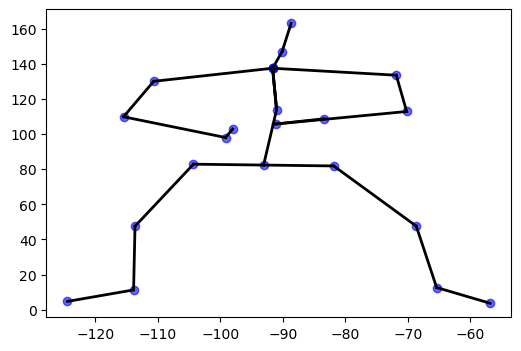

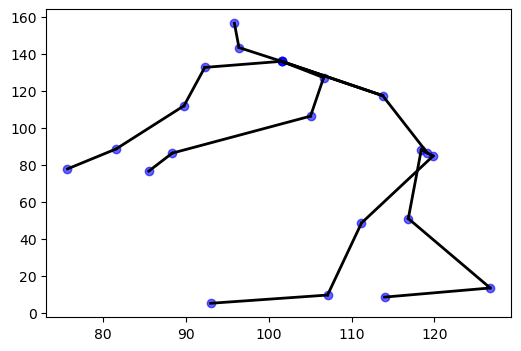

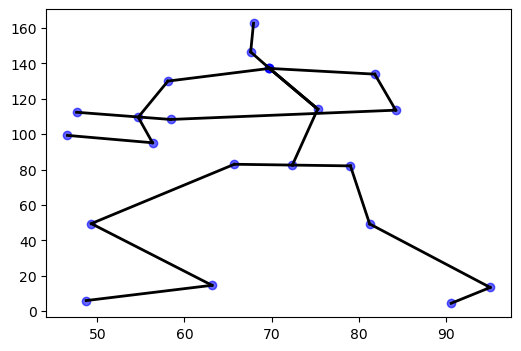

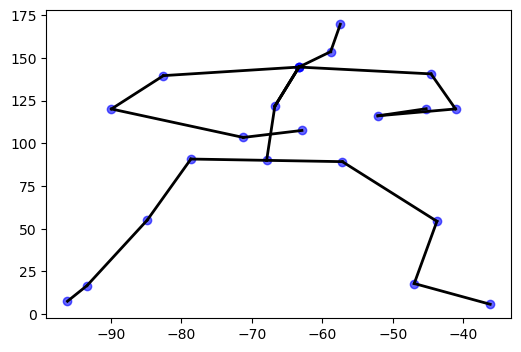

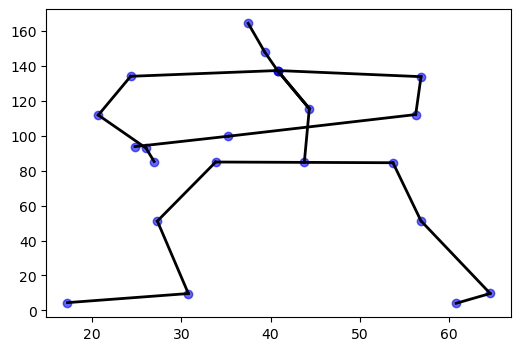

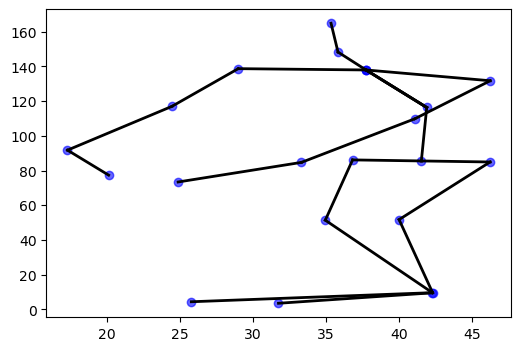

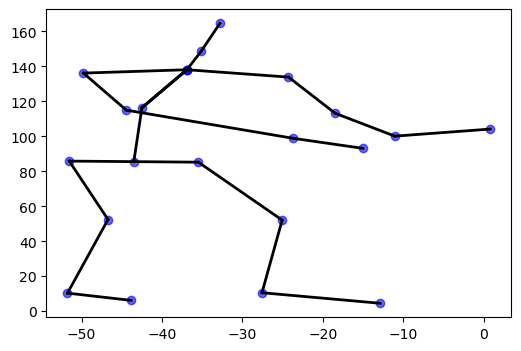

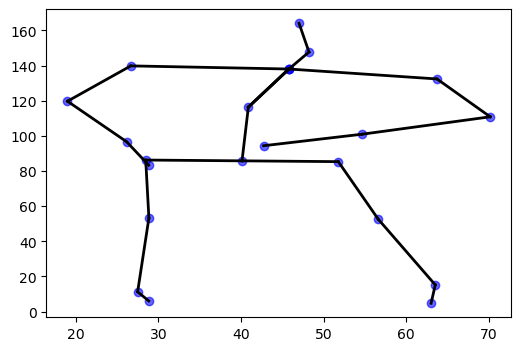

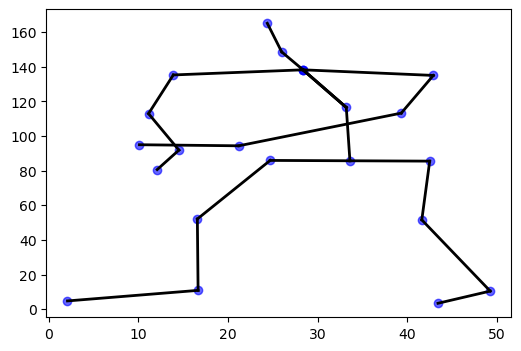

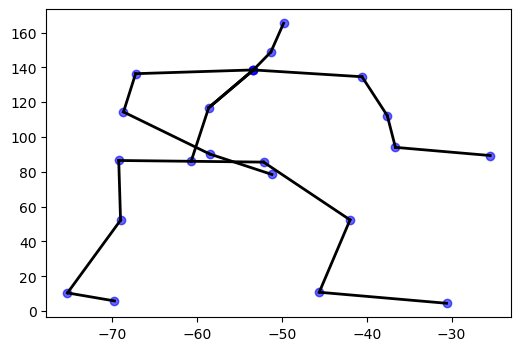

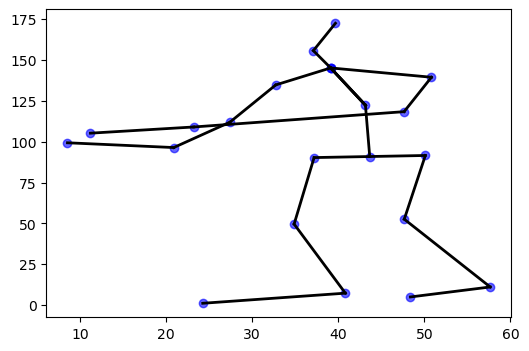

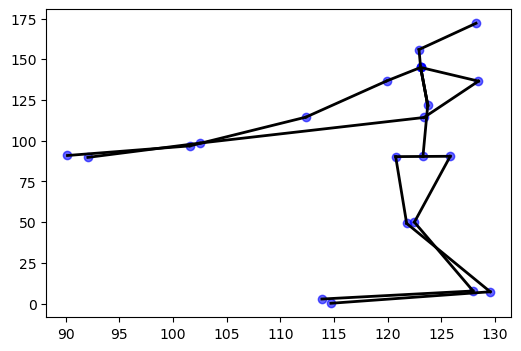

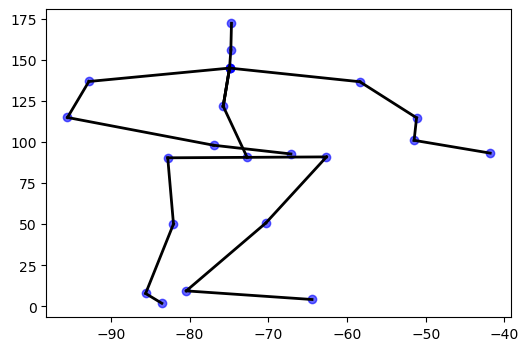

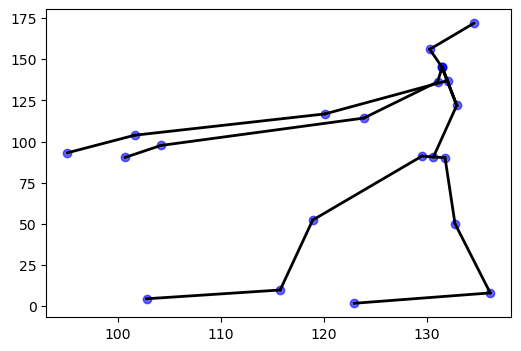

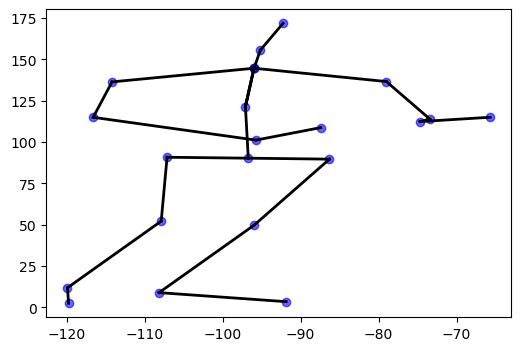

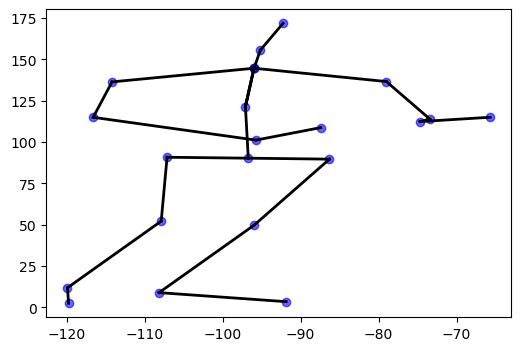

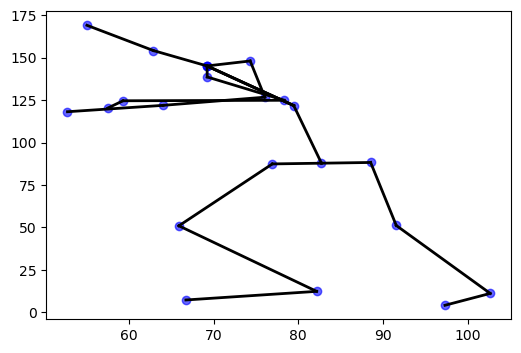

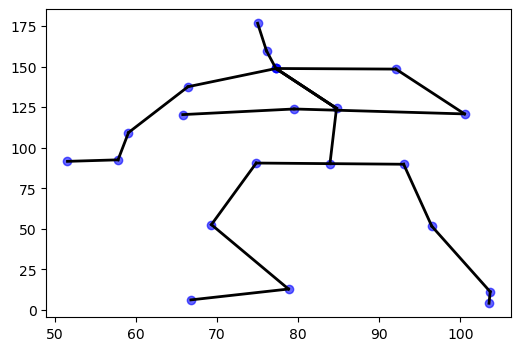

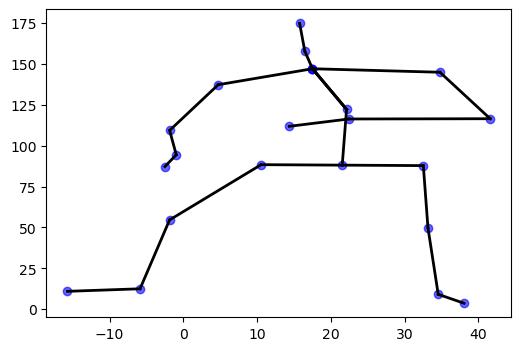

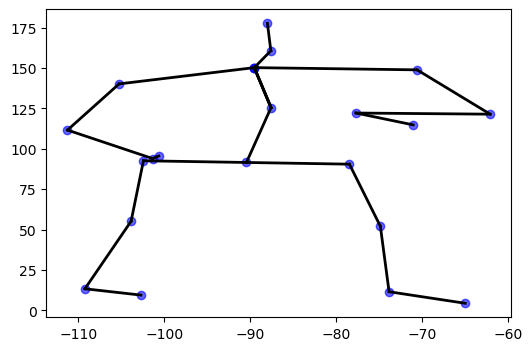

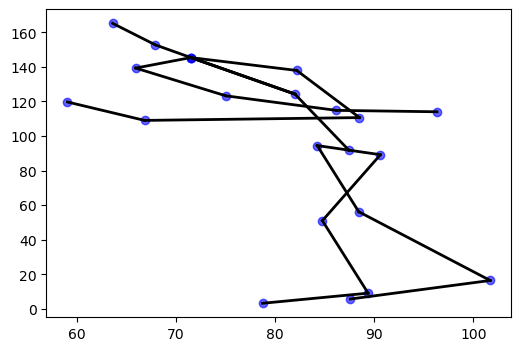

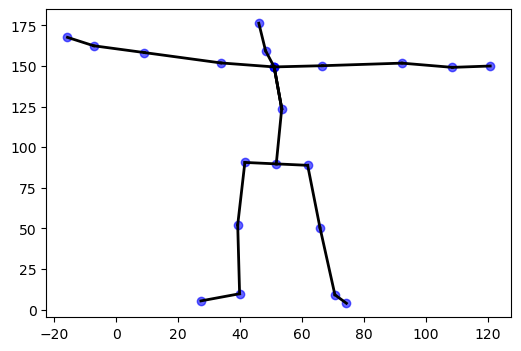

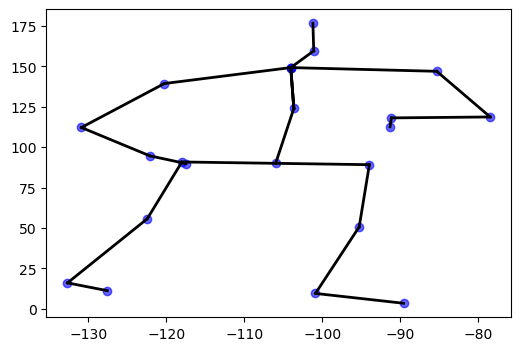

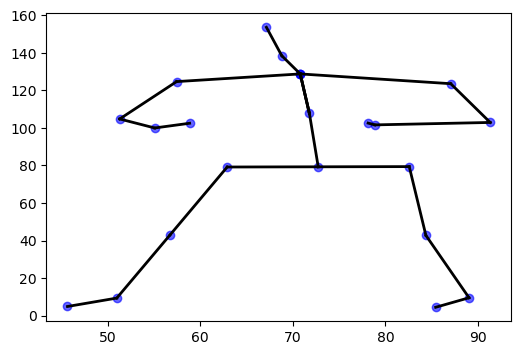

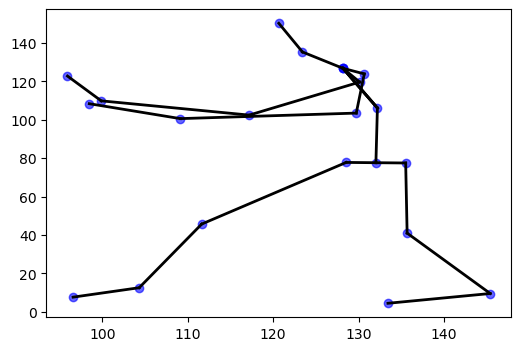

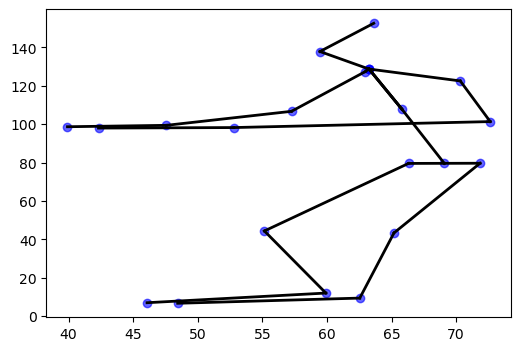

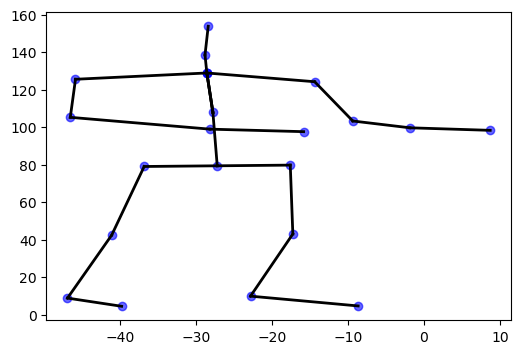

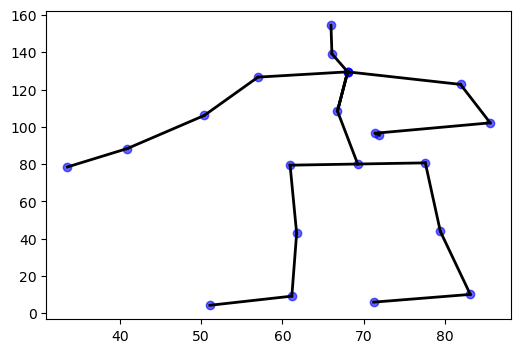

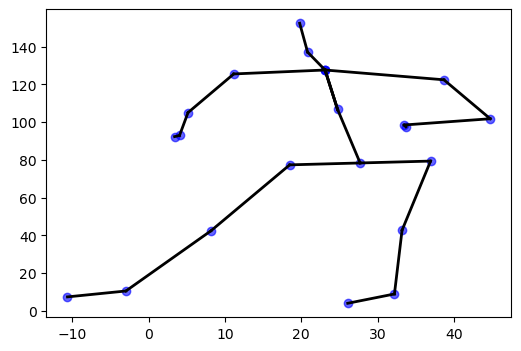

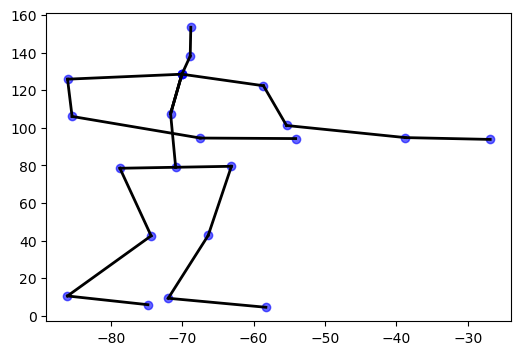

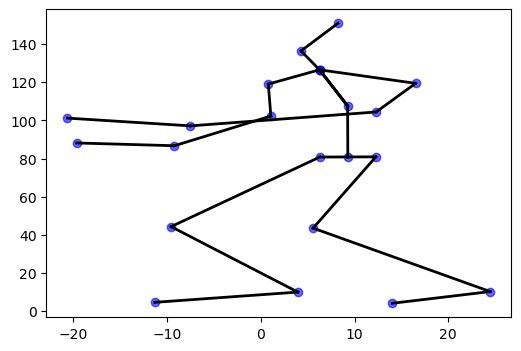

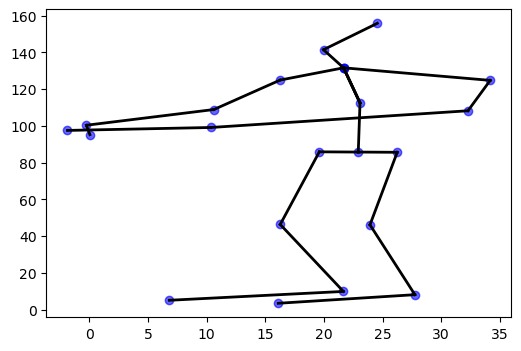

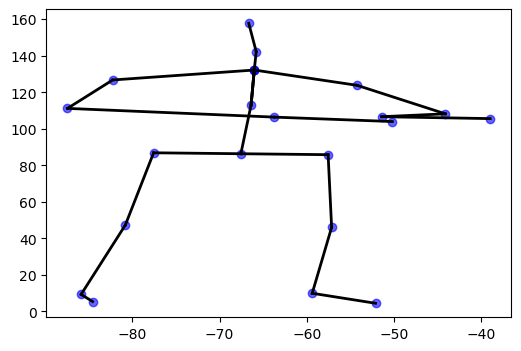

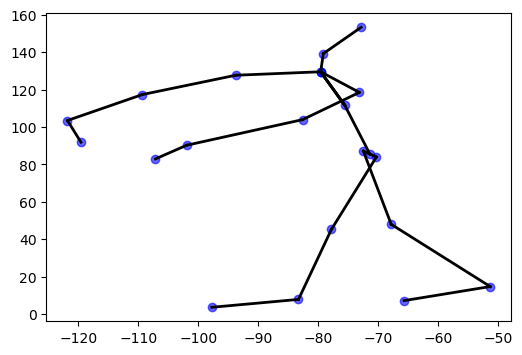

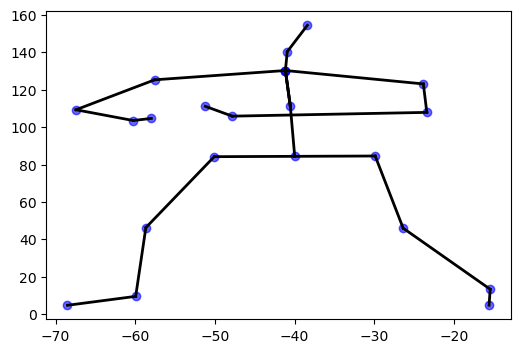

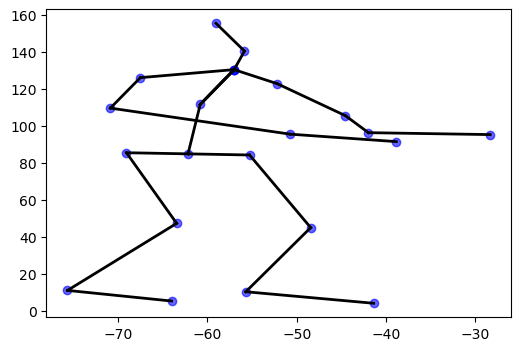

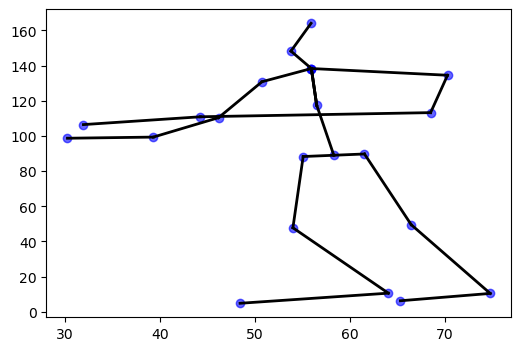

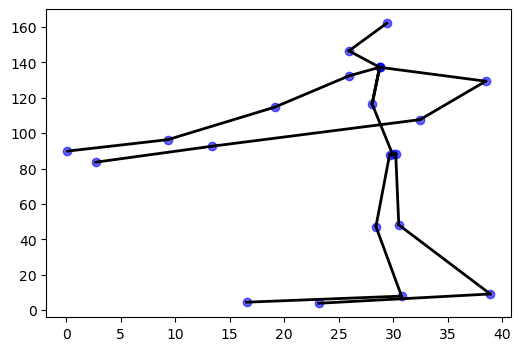

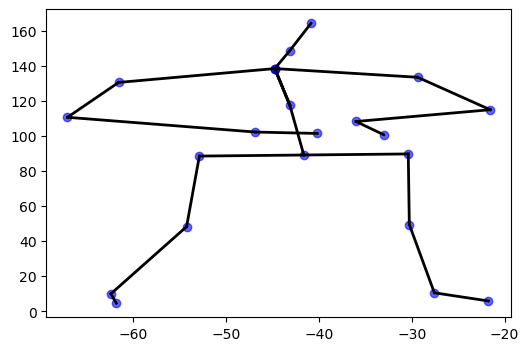

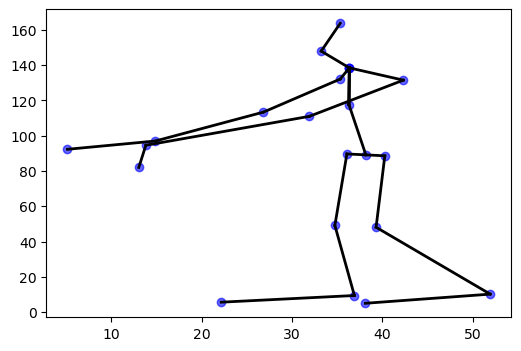

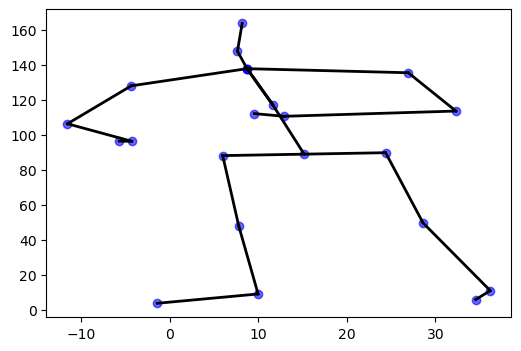

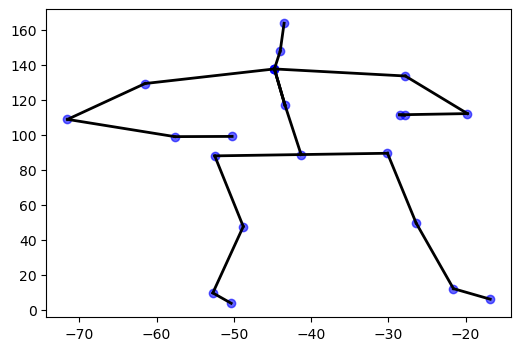

In [13]:
import os
from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure

# Función para procesar y graficar los archivos BVH
def process_and_plot_bvh(file_path, frame=10):
    parser = BVHParser()
    parsed_data = parser.parse(file_path)
    positions = mp.fit_transform([parsed_data])
    draw_stickfigure(positions[0], frame=frame, figsize=(6, 4))

# Directorio base donde se encuentran las carpetas de datos
base_dir = 'D:/Escritorio/datos_mocap/'

# Recorrer las carpetas 01, 02, 03, etc.
for folder_name in sorted(os.listdir(base_dir)):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Verificar que sea un directorio
    if os.path.isdir(folder_path):
        # Recorrer todos los archivos dentro de la carpeta
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            
            # Verificar que sea un archivo BVH
            if file_path.endswith('.bvh'):
                print(f'Processing {file_path}')
                process_and_plot_bvh(file_path)

## 6 movimientos por atleta

<Axes: >

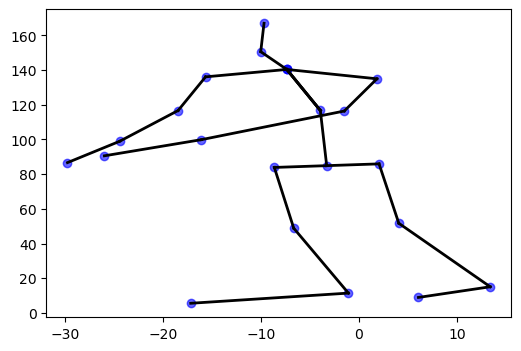

In [14]:
from pymo.parsers import BVHParser
#def fit_tranform(self,X):
       # self.fit(X)
        # return self.transform(X)
parser_2d = BVHParser()
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Derecha.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

<Axes: >

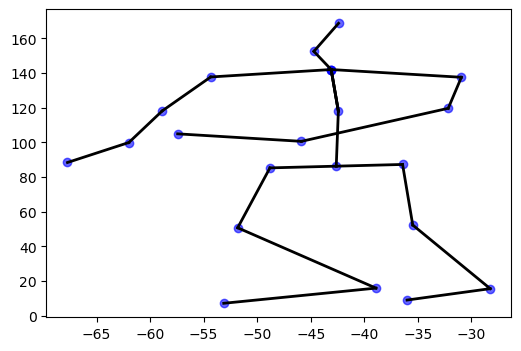

In [15]:
#2.adorozco_Remate_11seg.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Remate.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))


<Axes: >

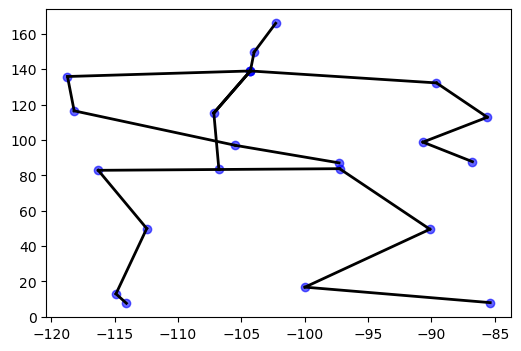

In [16]:
#3.adorozco_Reves_14seg.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Reves.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10,figsize=(6, 4))

<Axes: >

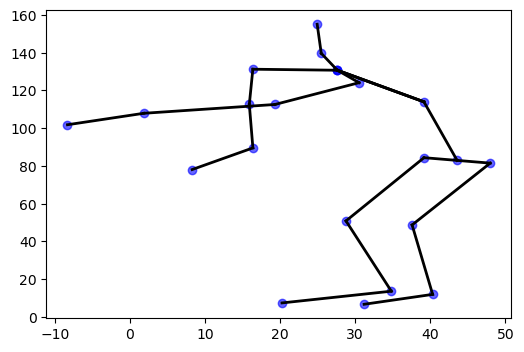

In [17]:
#4.adorozco_Servicio.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Servicio.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

<Axes: >

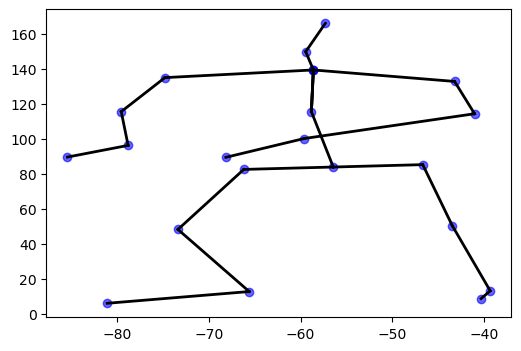

In [18]:
#5.adorozco_VDerecha.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_VDerecha.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

<Axes: >

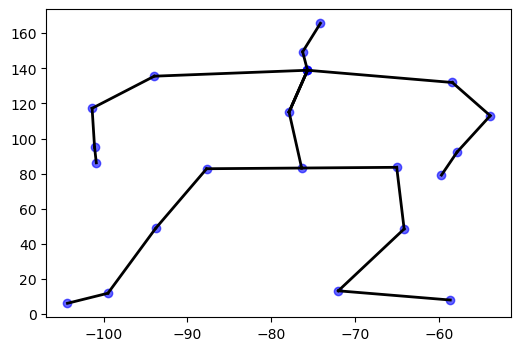

In [19]:
#6.adorozco_VReves.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_VReves.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

In [20]:
print(parser_2d)

# prueba imagen grilla

Processing D:/Escritorio/datos_mocap/01\adorozco_Derecha.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_Remate.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_Reves.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_Servicio.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_VDerecha.bvh
Processing D:/Escritorio/datos_mocap/01\adorozco_VReves.bvh


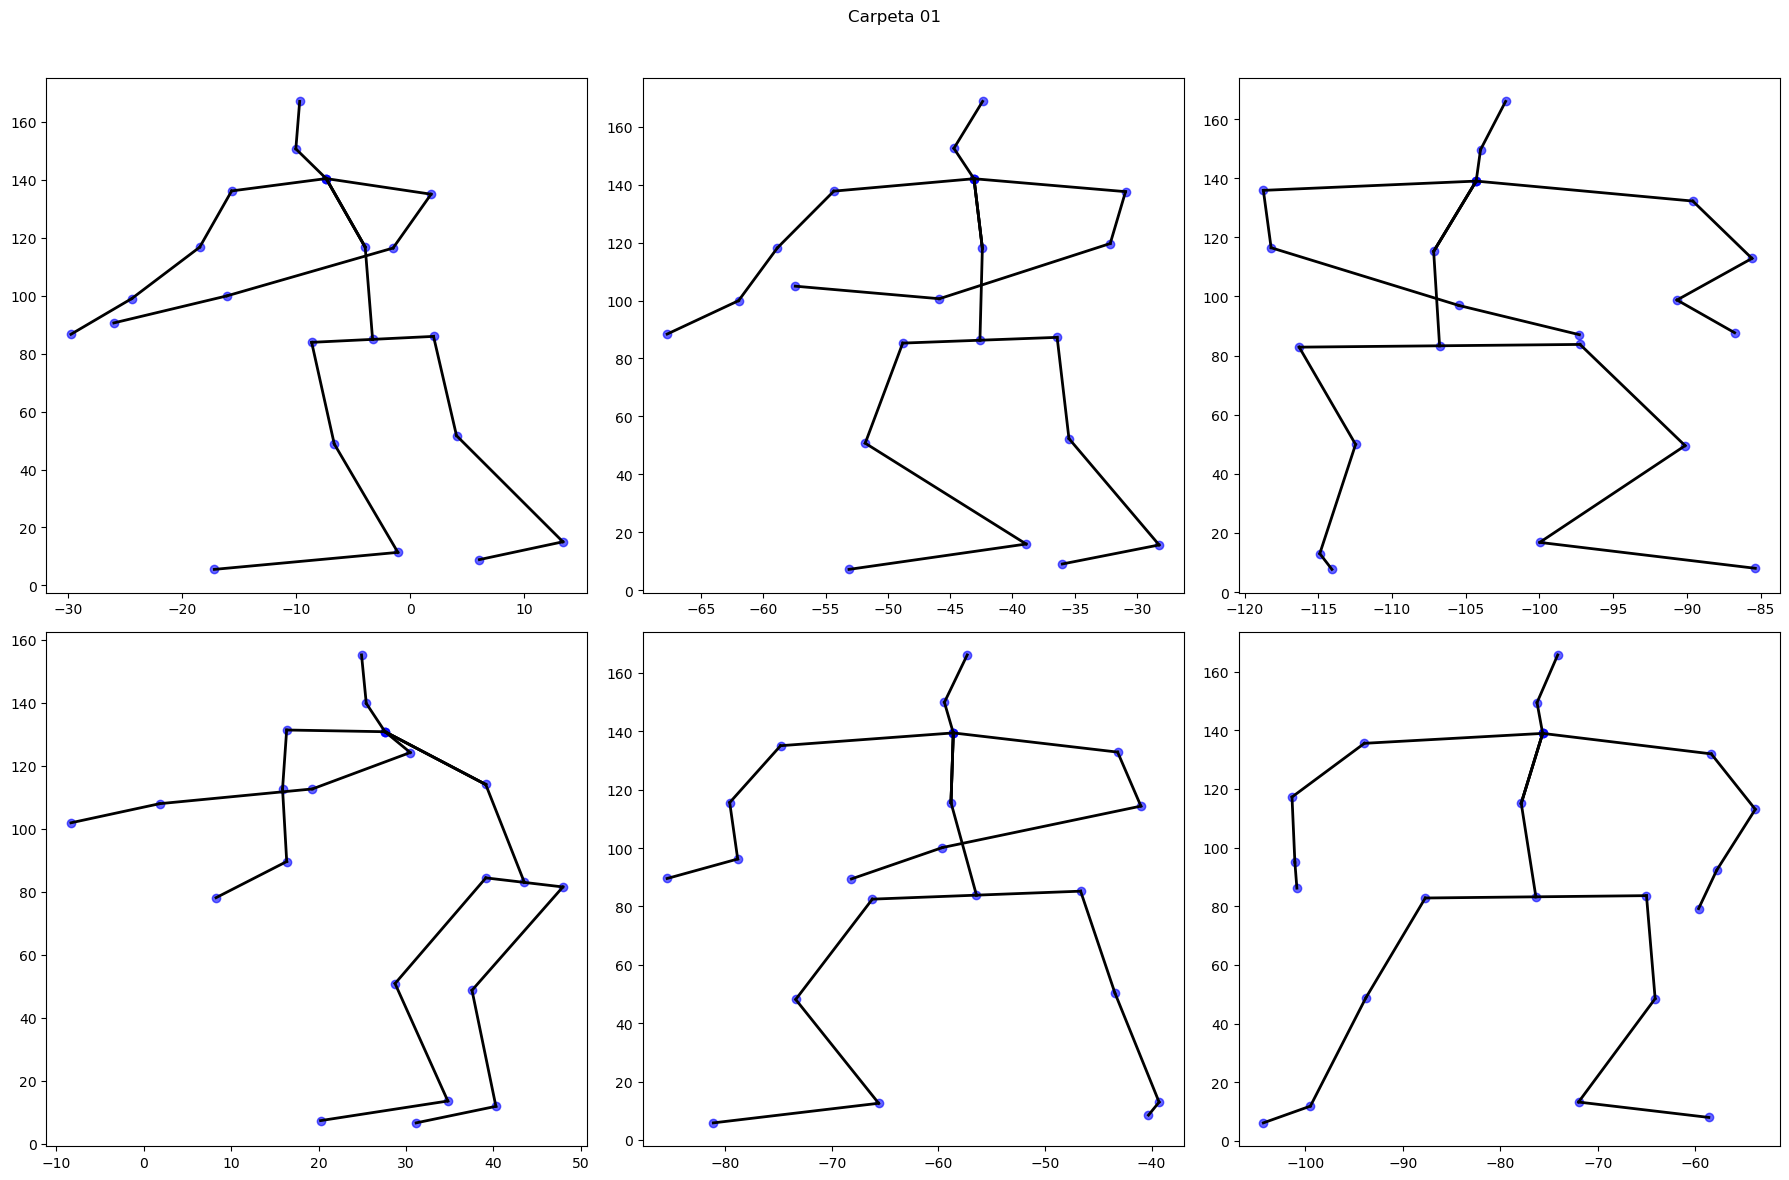

Processing D:/Escritorio/datos_mocap/07\jjmarin_Derecha.bvh
Processing D:/Escritorio/datos_mocap/07\jjmarin_Remate.bvh
Processing D:/Escritorio/datos_mocap/07\jjmarin_Reves.bvh
Processing D:/Escritorio/datos_mocap/07\jjmarin_Servicio.bvh
Processing D:/Escritorio/datos_mocap/07\jjmarin_VDerecha.bvh
Processing D:/Escritorio/datos_mocap/07\jjmarin_VReves.bvh


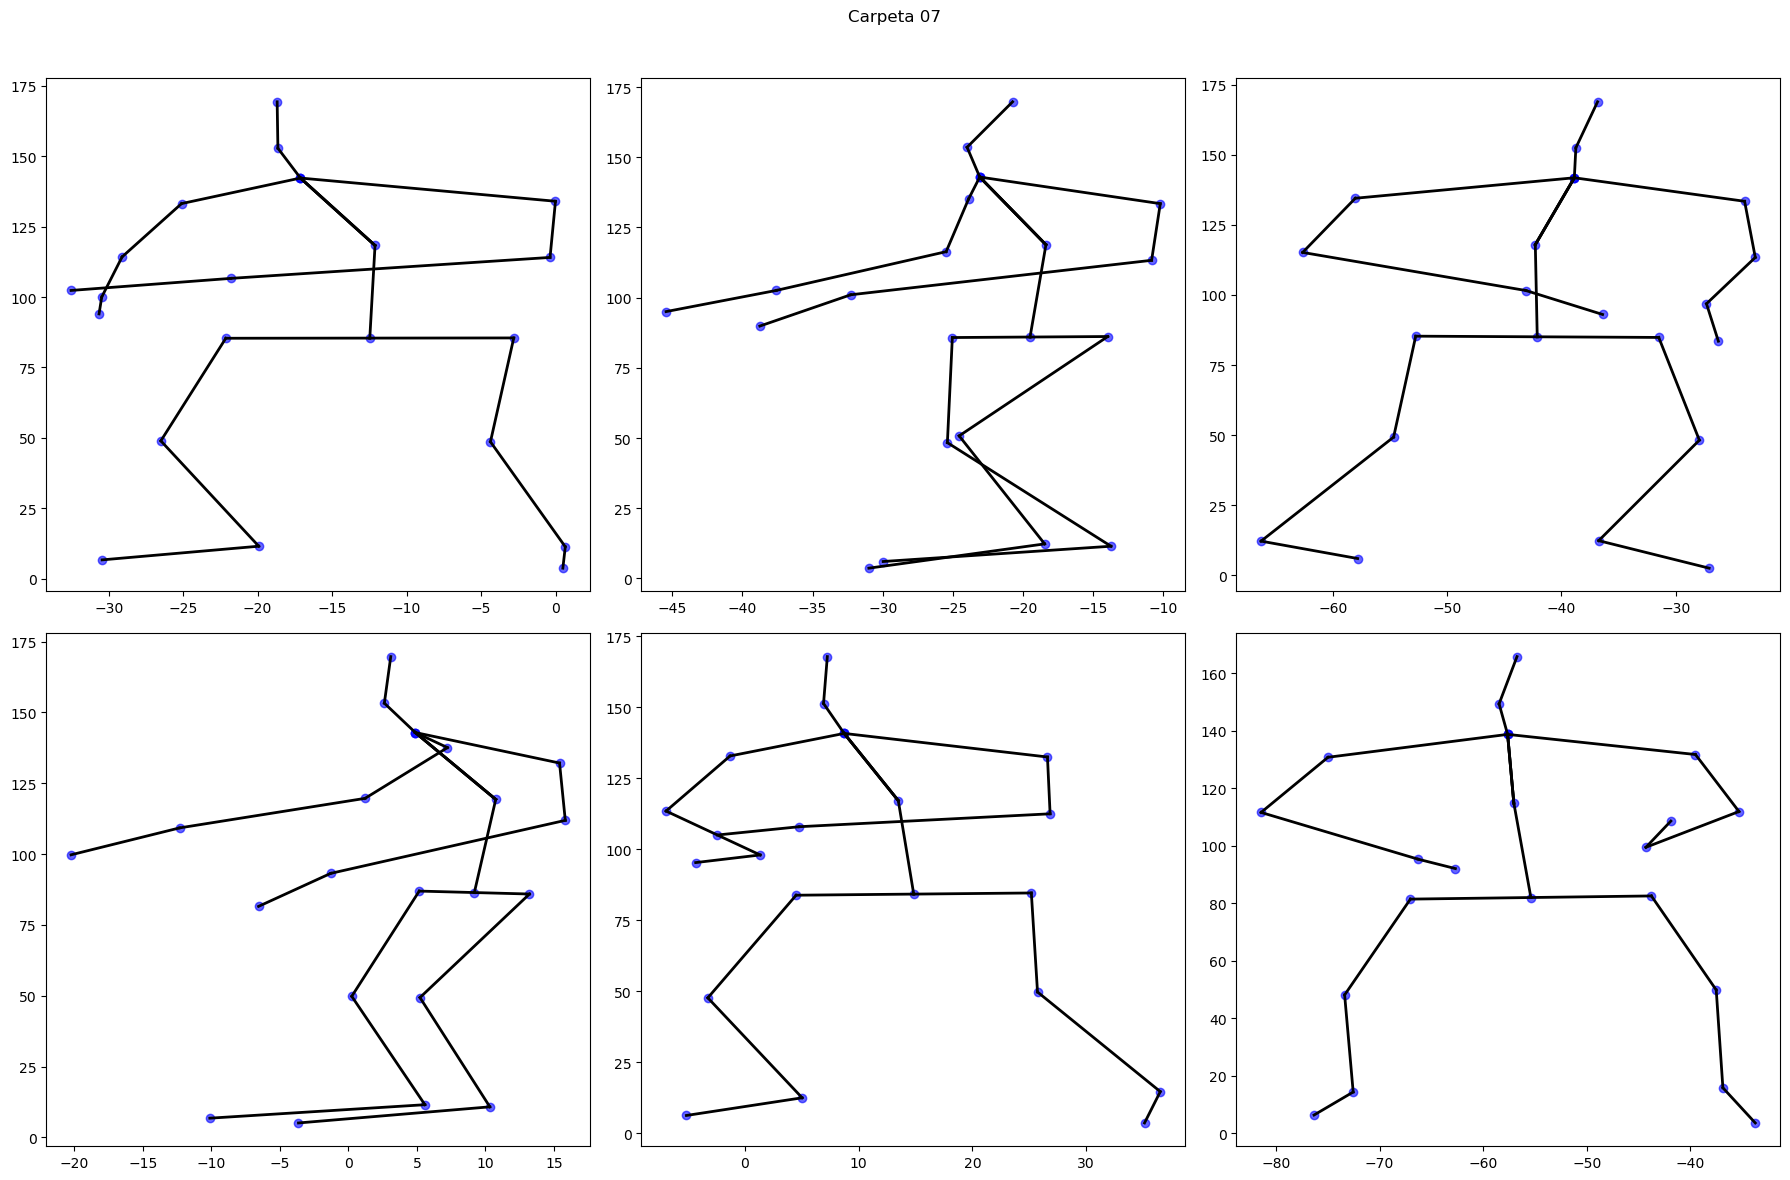

Processing D:/Escritorio/datos_mocap/15\secheverri_Derecha.bvh
Processing D:/Escritorio/datos_mocap/15\secheverri_Remate.bvh
Processing D:/Escritorio/datos_mocap/15\secheverri_Reves.bvh
Processing D:/Escritorio/datos_mocap/15\secheverri_Servicio.bvh
Processing D:/Escritorio/datos_mocap/15\secheverri_VDerecha.bvh
Processing D:/Escritorio/datos_mocap/15\secheverri_VReves.bvh


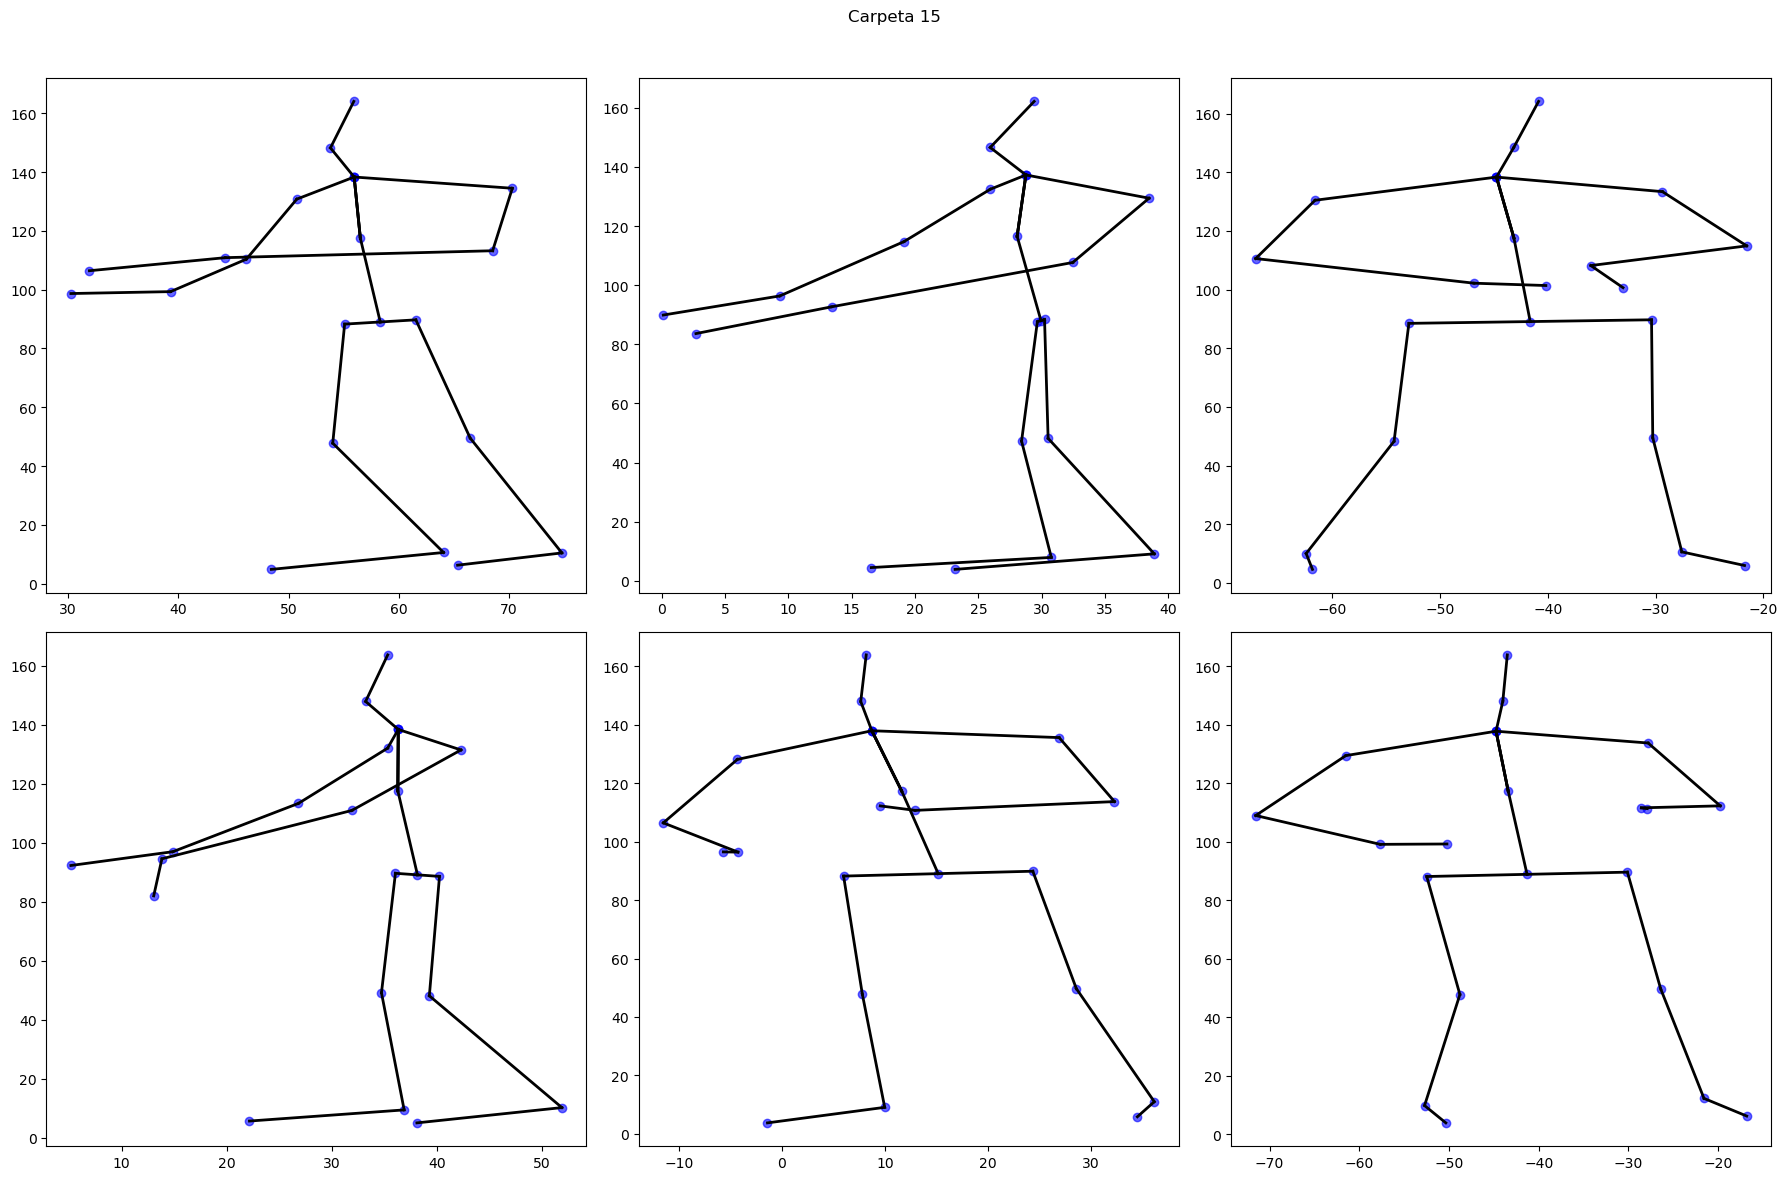

In [21]:
import os
from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure
import matplotlib.pyplot as plt

# Función para procesar y graficar los archivos BVH
def process_and_plot_bvh(file_path, ax, frame=10):
    parser = BVHParser()
    parsed_data = parser.parse(file_path)
    positions = mp.fit_transform([parsed_data])
    draw_stickfigure(positions[0], frame=frame, figsize=(6, 4), ax=ax)

# Directorio base donde se encuentran las carpetas de datos
base_dir = 'D:/Escritorio/datos_mocap/'
folders_to_process = ['01', '07', '15']

# Recorrer las carpetas especificadas
for folder_name in folders_to_process:
    folder_path = os.path.join(base_dir, folder_name)
    
    # Verificar que sea un directorio
    if os.path.isdir(folder_path):
        # Obtener todos los archivos .bvh dentro de la carpeta
        bvh_files = [f for f in os.listdir(folder_path) if f.endswith('.bvh')]
        
        # Configurar la grilla de subplots
        fig, axs = plt.subplots(2, 3, figsize=(18, 12)) # 2 filas y 3 columnas
        axs = axs.flatten() # Aplanar para fácil iteración
        
        # Procesar y graficar los archivos, máximo 6 por carpeta
        for i, file_name in enumerate(bvh_files[:6]):
            file_path = os.path.join(folder_path, file_name)
            print(f'Processing {file_path}')
            process_and_plot_bvh(file_path, ax=axs[i])
        
        # Ajustar y mostrar la figura
        plt.suptitle(f'Carpeta {folder_name}')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


## CLÚSTER
tiempo que se demore haciendo los cluster. KMEANS - espectral clustering agrupamiento, 100 frames dentro del video. tomar y agrupar con un criterio de agrupamiento tomar los frame mas relevantes, un movimiento de una jugada de tenis tiene unas posiciones claves son las que me dicen la informacion si lo esta haciendo bien o mal.  Expertos vs Amateur

In [22]:
start = timeit.timeit()
k=50
dist = SHECCO(k=k)
Xa = np.zeros((len(pos_cent),k,69)) #matriz
ind = np.zeros((len(pos_cent),k))
for i in range(len(pos_cent)):
  Z = np.array(pos_cent[i][0].values)
  Xc,indx = dist.Kmeans_Mocap(Z)
  print("****")
  print(Xc)
  Xa[i,:,:]= Xc
  ind[i,:] = indx
end = timeit.timeit()
print(end-start)
ind=ind.astype(int)

****
[[  0.         153.768478    46.706169   ...   3.67685502 231.74444302
   57.83450585]
 [  0.         162.124992    96.414827   ...   2.72160852 241.87151027
  109.50129012]
 [  0.         132.435307    -3.469181   ...   8.47910061 213.72818823
    3.7991956 ]
 ...
 [  0.         160.434807   105.875821   ...  -5.83634271 240.0557126
  117.65475528]
 [  0.         149.161805    57.475966   ...   5.63070799 230.88064518
   56.10622896]
 [  0.         164.582542    96.93322    ...  -0.71739162 245.6576625
  100.99967891]]
****
[[  0.         184.381118    84.658213   ... -38.0925301  240.41519315
  114.18093189]
 [  0.         141.551739    70.646522   ...  12.19307093 216.80853416
   76.72500581]
 [  0.         166.765716    85.544538   ...  13.80802908 240.98897068
   91.43305426]
 ...
 [  0.         155.408096    58.091672   ...  21.36353471 227.5342869
   69.27744952]
 [  0.         155.507148    71.292807   ...  16.50979929 222.83983934
  101.05348903]
 [  0.         136.409302

## PCA 
cada punto es un frame. resultados de los cluster son los centroides los movimientos más representativos levantar el codo mas informacion que la raqueta ejemplo- algoritmo para reduccion de dimensionalidad en este caso PCA 

trayectoria por cada judagor

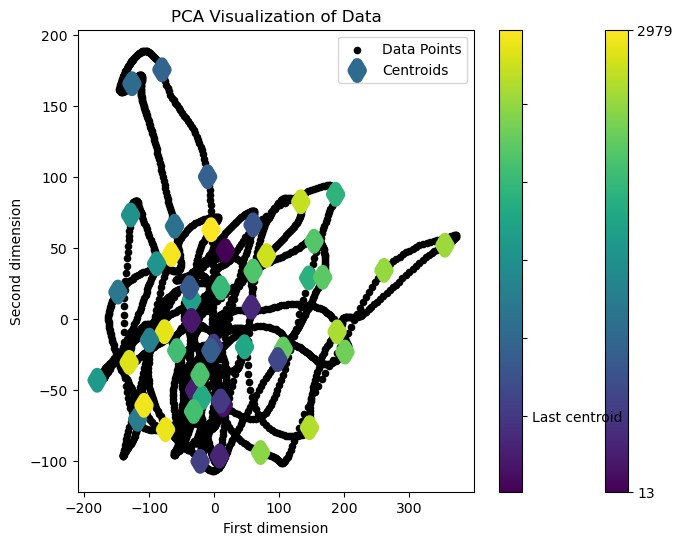

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

v = 1
Z = pos_cent[v][0].values  
pca = PCA(n_components=2) # me diga a PCA cuales son las dimensiones más representativas
x = pca.fit_transform(Z)

# Plot
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura según sea necesario
plt.scatter(x[:, 0], x[:, 1], color='k', s=20, label='Data Points')  # Ajusta el tamaño de los marcadores según sea necesario
plt.scatter(x[ind[v], 0], x[ind[v], 1], marker='d', s=50, linewidths=8, c=ind[v], label='Centroids')
plt.colorbar().set_ticks([np.min(ind[v]), np.max(ind[v])])
plt.colorbar().set_ticklabels(['First centroid', 'Last centroid'])
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('PCA Visualization of Data')
# Descomenta el siguiente bloque si deseas agregar etiquetas de los puntos
# for j in range(ind.shape[1]):
#     plt.text(x[ind[v,j], 0], x[ind[v,j], 1], ind[v,j], fontsize=12, color='r')

# Guardar la figura
plt.savefig('throw_pca.pdf', bbox_inches='tight')

# Mostrar la figura
plt.legend()
plt.show()


# Parámetros Kernels

## definir lista de movimientos

In [24]:
# We define the name of the labels according to the type of activity
list_mov = ['derecha', 'remate', 'reves', 'servicio', 'vderecha', 'vreves']
direcctorio_principal = 'D:/Escritorio/datos_mocap/'

In [25]:
# Sigma parameters is computed
Sigx = np.zeros((Xa.shape[0]))
#Sigy = np.zeros((Y.shape[0]))
for i in range(Xa.shape[0]):
  Dx = pairwise_distances(Xa[i],Xa[i])
  Sigx[i] = np.median(Dx)
  #Dy = pairwise_distances(Y[i],Y[i])
  #Sigy[i] = np.median(Dy)
Sigma_x = np.median(Sigx)
Sigma_y = Sigma_x

In [26]:
Dx

array([[0.00000000e+00, 2.41155704e+02, 2.54767638e+02, ...,
        2.72204562e+02, 1.51595749e+02, 2.95666212e+02],
       [2.41155704e+02, 1.52587891e-05, 3.66725102e+02, ...,
        1.45861964e+02, 2.90879041e+02, 1.10256536e+02],
       [2.54767638e+02, 3.66725102e+02, 0.00000000e+00, ...,
        3.58690995e+02, 2.08925519e+02, 4.15066957e+02],
       ...,
       [2.72204562e+02, 1.45861964e+02, 3.58690995e+02, ...,
        0.00000000e+00, 3.18398687e+02, 1.32157632e+02],
       [1.51595749e+02, 2.90879041e+02, 2.08925519e+02, ...,
        3.18398687e+02, 1.52587891e-05, 3.55109704e+02],
       [2.95666212e+02, 1.10256536e+02, 4.15066957e+02, ...,
        1.32157632e+02, 3.55109704e+02, 0.00000000e+00]])

In [27]:
print(len(Dx))

50


In [28]:
print(dist)

SHECCO()


# Matriz de disimilaridad

adorozco_Derecha.bvh
adorozco_Remate.bvh
adorozco_Reves.bvh
adorozco_Servicio.bvh
adorozco_VDerecha.bvh
adorozco_VReves.bvh
astrejos_Derecha.bvh
astrejos_Remate.bvh
astrejos_Reves.bvh
astrejos_Servicio.bvh
astrejos_VDerecha.bvh
astrejos_VReves.bvh
cferrero_Derecha.bvh
cferrero_Remate.bvh
cferrero_Reves_21seg.bvh
cferrero_Servicio.bvh
cferrero_VDerecha.bvh
cferrero_VReves.bvh
jangel_Derecha.bvh
jangel_Remate.bvh
jangel_Reves.bvh
jangel_Servicio.bvh
jangel_VDerecha.bvh
jangel_VReves.bvh
jarua_Derecha_18seg.bvh
jarua_Remate.bvh
jarua_Reves.bvh
jarua_Servicio.bvh
jarua_VDerecha.bvh
jarua_VReves.bvh
jdescobar_Derecha.bvh
jdescobar_Remate.bvh
jdescobar_Reves 20 seg.bvh
jdescobar_Reves.bvh
jdescobar_Servicio.bvh
jdescobar_VDerecha.bvh
jdescobar_VReves.bvh
jjmarin_Derecha.bvh
jjmarin_Remate.bvh
jjmarin_Reves.bvh
jjmarin_Servicio.bvh
jjmarin_VDerecha.bvh
jjmarin_VReves.bvh
jduribe_Derecha.bvh
jduribe_Remate.bvh
jduribe_Reves.bvh
jduribe_Servicio.bvh
jduribe_VDerecha.bvh
jduribe_VReves.bvh
jgaco

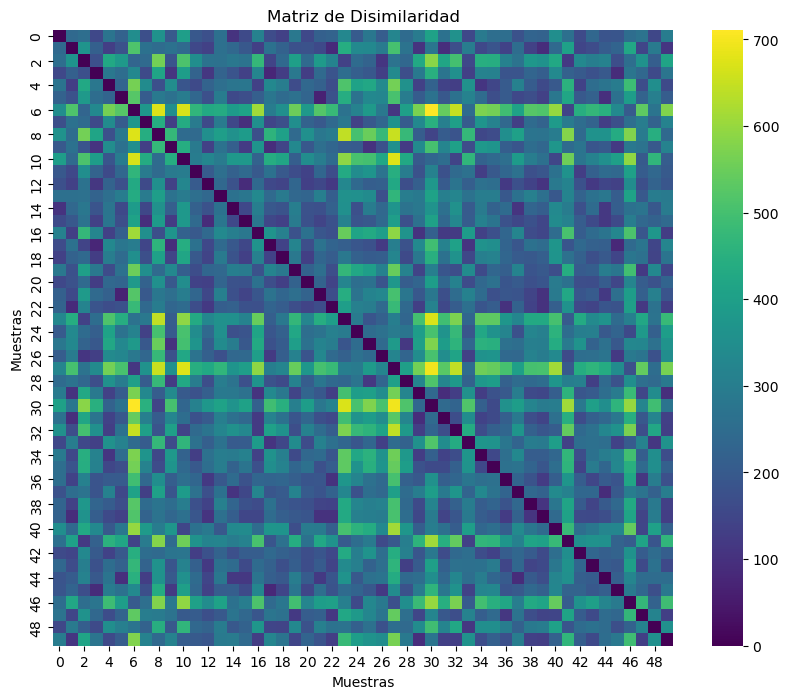

In [29]:
import os
import numpy as np
import joblib
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las etiquetas según el tipo de actividad
list_mov = ['derecha', 'remate', 'reves', 'servicio', 'vderecha', 'vreves']
X = []
nlabs = []
filename = 'Data_clus_CMU_demo'

# Suponiendo que 'list_folder' y 'direcctorio_principal' ya están definidos
for j in range(len(list_folder)):
    list_trials = os.listdir(direcctorio_principal + list_folder[j])
    list_trials = sorted(list_trials)
    for i in range(min(len(list_trials), len(Xa))):  # Usar el menor entre el tamaño de list_trials y Xa
        print(list_trials[i])
        X.append(Xa[i])  # Agregar el elemento de Xa a la lista X
    nlabs.append(len(list_trials))  # Guardar el número de pruebas de cada carpeta

# Verificar si 'list_mov' y 'nlabs' tienen el mismo tamaño
if len(list_mov) == len(nlabs):
    labels_name = np.repeat(list_mov, nlabs, axis=0)
else:
    # Ajustar para que 'list_mov' y 'nlabs' coincidan en tamaño
    min_len = min(len(list_mov), len(nlabs))
    labels_name = np.repeat(list_mov[:min_len], nlabs[:min_len], axis=0)

# Crear las etiquetas según las carpetas
labels = np.repeat(list_folder, nlabs, axis=0)
labels = labels.reshape(-1, 1)
labels_name = labels_name.reshape(-1, 1)

# Agregar las etiquetas a la lista X
X.append(labels)

# Guardar los datos en un archivo .pkl
joblib.dump(X, filename + ".pkl")

# Cálculo de la matriz de disimilaridad y sigma
Sigx = np.zeros((len(Xa)))
for i in range(len(Xa)):
    Dx = pairwise_distances(Xa[i], Xa[i])
    Sigx[i] = np.median(Dx)

Sigma_x = np.median(Sigx)
Sigma_y = Sigma_x

print("Sigma_x:", Sigma_x)
print("Sigma_y:", Sigma_y)

# Graficar la matriz de disimilaridad
plt.figure(figsize=(10, 8))
sns.heatmap(Dx, cmap='viridis', annot=False)
plt.title("Matriz de Disimilaridad")
plt.xlabel("Muestras")
plt.ylabel("Muestras")
plt.show()

In [30]:
print(labels_name)

[['derecha']
 ['derecha']
 ['derecha']
 ['derecha']
 ['derecha']
 ['derecha']
 ['remate']
 ['remate']
 ['remate']
 ['remate']
 ['remate']
 ['remate']
 ['reves']
 ['reves']
 ['reves']
 ['reves']
 ['reves']
 ['reves']
 ['servicio']
 ['servicio']
 ['servicio']
 ['servicio']
 ['servicio']
 ['servicio']
 ['vderecha']
 ['vderecha']
 ['vderecha']
 ['vderecha']
 ['vderecha']
 ['vderecha']
 ['vreves']
 ['vreves']
 ['vreves']
 ['vreves']
 ['vreves']
 ['vreves']
 ['vreves']]


Ajustando labels de tamaño 99 a 50


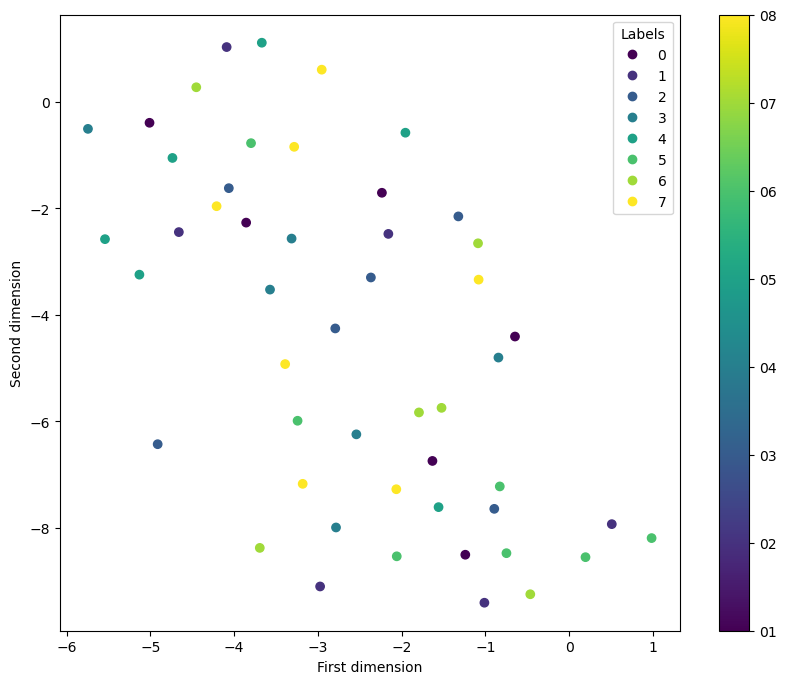

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Visualizar espacio generado por las distancias con t-SNE
red = TSNE(metric='precomputed', perplexity=20.0, init='random')
ztrain = red.fit_transform(Dx)

# Asegúrate de que labels tenga el mismo tamaño que ztrain
if len(labels) != len(ztrain):
    print(f"Ajustando labels de tamaño {len(labels)} a {len(ztrain)}")
    labels = np.resize(labels, len(ztrain))

# Crear un mapeo dinámico
unique_labels = np.unique(labels)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
labels_numeric = np.array([label_map[label] for label in labels])

# Visualizar espacio generado por las distancias con t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(ztrain[:, 0], ztrain[:, 1], c=labels_numeric, cmap='viridis')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')

# Agregar barra de color
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(len(unique_labels)))
cbar.set_ticklabels(unique_labels)

plt.savefig('TSNE_CMU.pdf', bbox_inches='tight')
plt.legend(*scatter.legend_elements(), title="Labels")
plt.show()




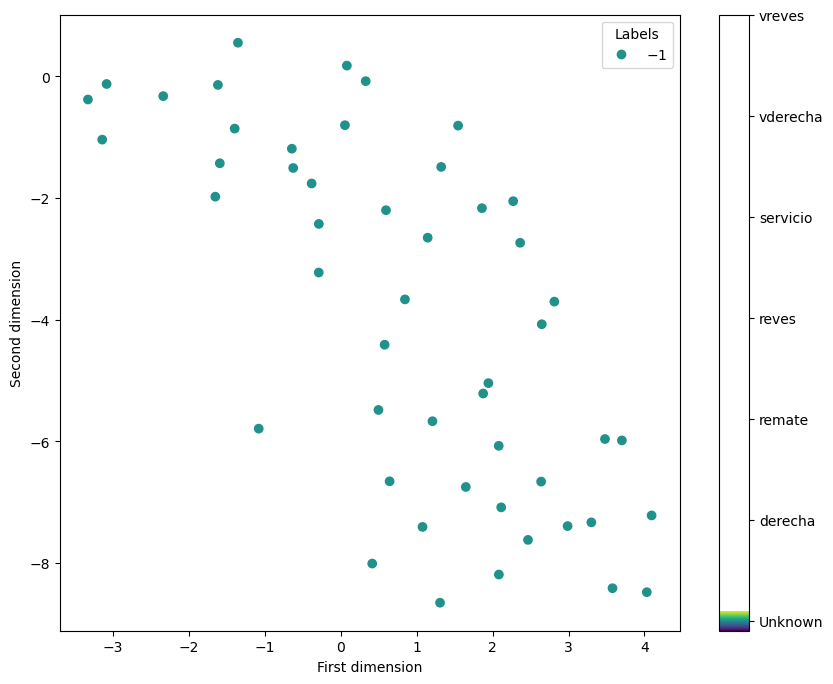

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Visualizar espacio generado por las distancias con t-SNE
red = TSNE(metric='precomputed', perplexity=20.0, init='random')
ztrain = red.fit_transform(Dx)

# Asegúrate de que labels tenga el mismo tamaño que ztrain
if len(labels) != len(ztrain):
    print(f"Ajustando labels de tamaño {len(labels)} a {len(ztrain)}")
    labels = np.resize(labels, len(ztrain))

# Convertir labels a valores numéricos si no lo son
labels_numeric = []
for label in labels:
    if label in list_mov:
        labels_numeric.append(list_mov.index(label))
    else:
        # Mapear a un valor específico si no está en list_mov
        labels_numeric.append(-1)  # Por ejemplo, -1 si no está en list_mov

labels_numeric = np.array(labels_numeric)

# Visualizar espacio generado por las distancias con t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(ztrain[:, 0], ztrain[:, 1], c=labels_numeric, cmap='viridis')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')

# Agregar barra de color
cbar = plt.colorbar(scatter)
cbar.set_ticks(np.arange(-1, len(list_mov)))
cbar.set_ticklabels(['Unknown'] + list_mov)

plt.savefig('TSNE_CMU.pdf', bbox_inches='tight')
plt.legend(*scatter.legend_elements(), title="Labels")
plt.show()
